# Term-Deposit-Marketing-2020

A company is investigating its call center data to understand what factors are most useful for determining what will influence call success. The call center data is looking at the demographics of its term deposit subscription attempts and attempting to look at what major features are predictive if someone will be more likely to subscribe to the service. Currently, the success rate is very low, but the goal of this project will be to raise that success rate to a higher level and make the results able to be easily interpreted by the business for future decision-making when it comes to making contact with potential subscribers. Several major pieces of identifiable attributes were made available, however any pieces of personally identifiable information were not included.

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, precision_score
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv(r'C:\Users\crozi\Documents\term-deposit-marketing-2020.csv')

#seed = random.randint(1000, 9999)
seed = 3187
print(seed)
#Seeds with good results for subscribers/non-subscribers: 9151, 3187

3187


### Data Overview

Much of the data provided for this task was categorical, but we can still pull some information from the numerical data provided. For instance, the age of respondents varies greatly with 19 being the youngest and 95 being the oldest. The average age of respondents was around 40, but it's skewed heavily since we can observe that many of the participants were less than half the age of the oldest participant. Balances also had a wide distribution, with several balances including the minimum actually being negative. The highest vastly exceeded the mean, and was almost 80 times the 75% quartile. Duration and campaigns varied greatly as well with the maximum often being many times what the 75% quartile was. This indicates that there are many outliers in the data that can skew the results.

In [3]:
df. describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


Describing the data is slightly difficult in this scenario as there are only four numerical categories in the data that are of interest to us, the age of the respondent, balance of their account, the duration of the subscription, and how often the respondent was contacted during the campaign. Of the 40,000 individuals reported in the survey data, the age had a wide variance in the data. The youngest respondent was recorded at 19, while the oldest respondent was 95. The average age was little older than 40, with most of the data skewed towards individuals in their 30's. The balance of the individuals account had some variance as well. While the average individual had a balance around 1,274, several accounts had significantly less or more. The lowest balance actually had a negative value at -8,019 dollars. The highest account value was recorded at 102,127. Since the average above only has a standard deviation of 2,903, this indicates how far these outlier values can reach. The duration of the subscription was also interesting, while the mean value was around 254, it might be skewed as the largest recorded value is nearly 25 times that at 4,918. The final piece of numerical data of interest is how many times respondents were contacted during the campaign. All respondents were contacted at least during the campaign but another outlier can be seen as the max number of times a respondent was contacted is 63!

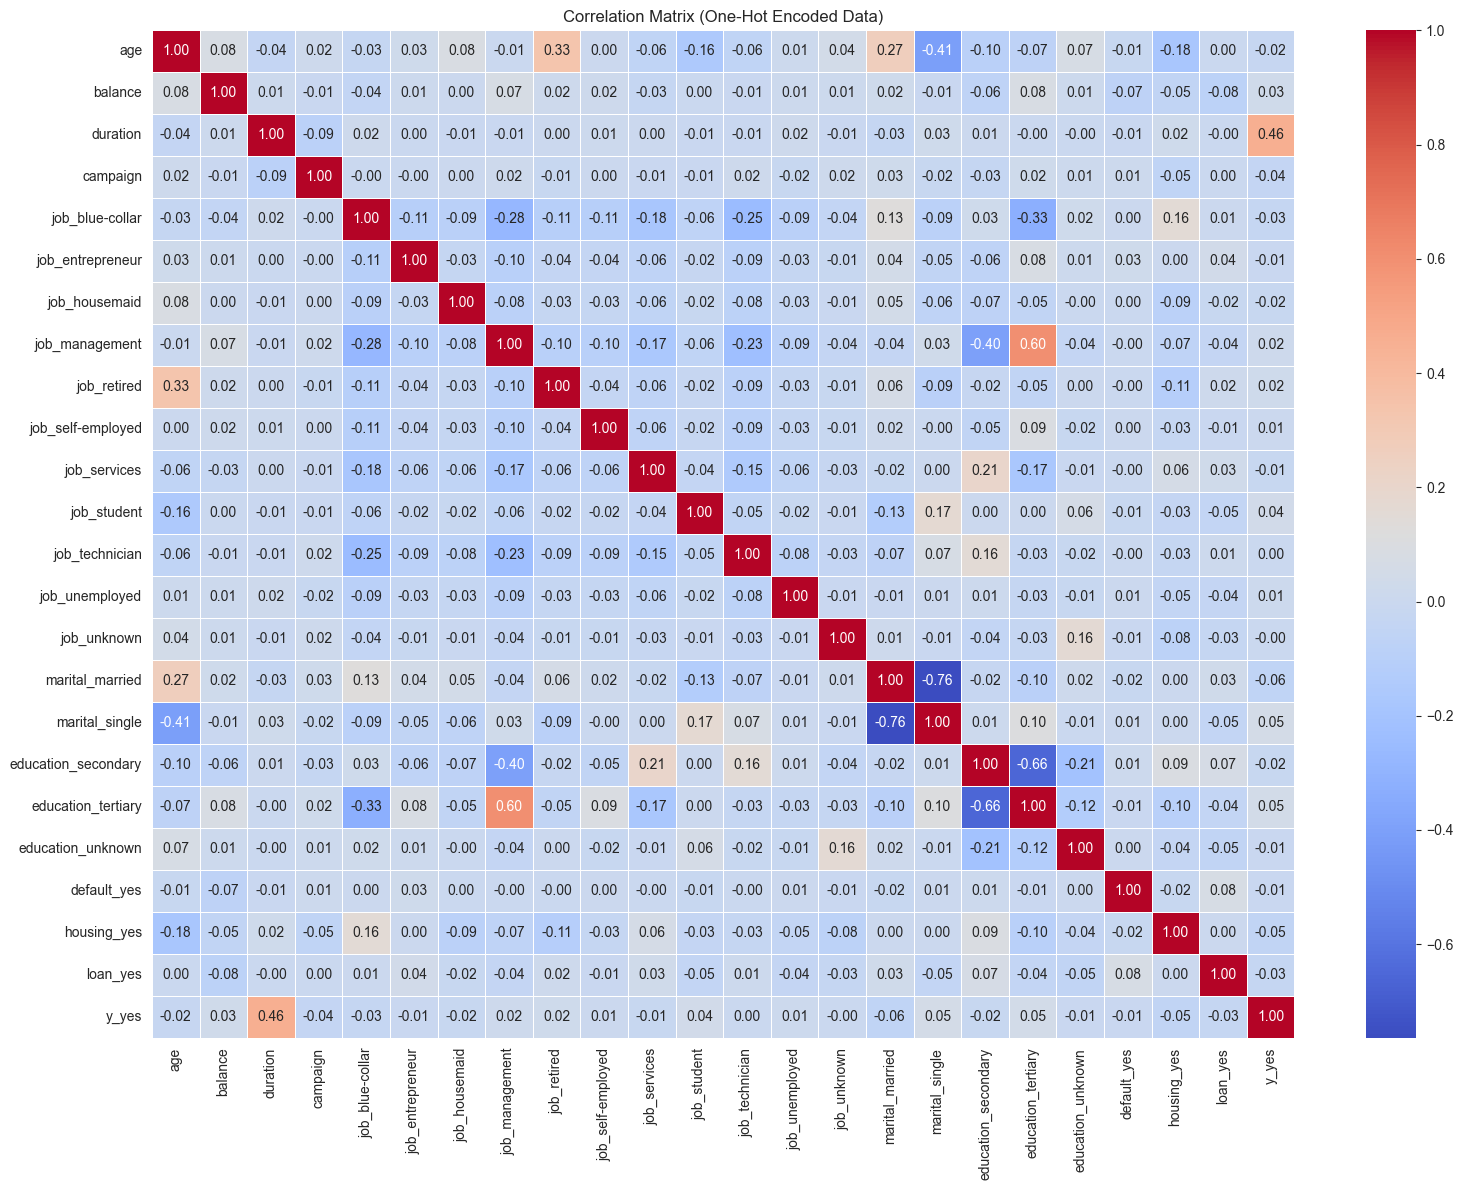

In [4]:
df = df.drop(['day', 'month', 'contact'], axis=1)

df_encoded = pd.get_dummies(df, drop_first=True)

corr = df_encoded.corr()

plt.figure(figsize=(16, 12))
sb.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (One-Hot Encoded Data)')
plt.tight_layout()
plt.show()

A custom correlation map needed to be generated with the categorical data presented. Several columns are given different values based on the categorical data they represent and to help further isolate them for comparison against the numerical data. In addition, instead of sticking to one color, a 'coolwarm' scheme was used to help show the colors that stick out more with cooler colors representing a higher negative correlation and warmer colors representing a higher positive correlation.



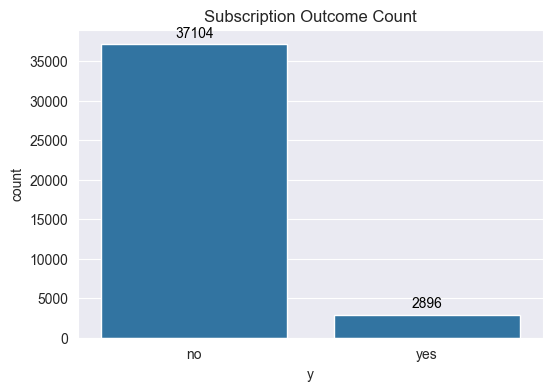

In [5]:
plt.figure(figsize=(6, 4))
ax = sb.countplot(data=df, x='y')
plt.title("Subscription Outcome Count")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.show()

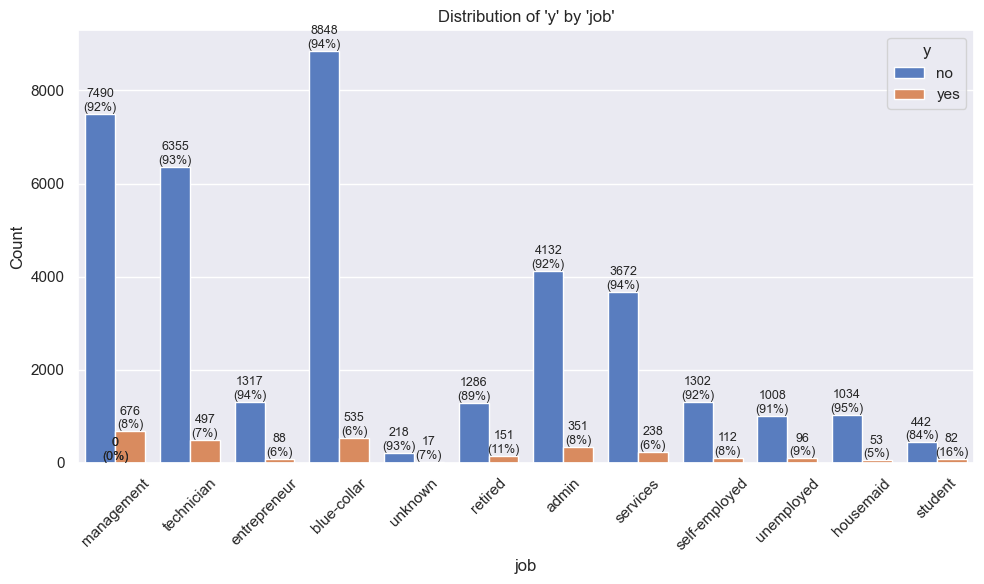

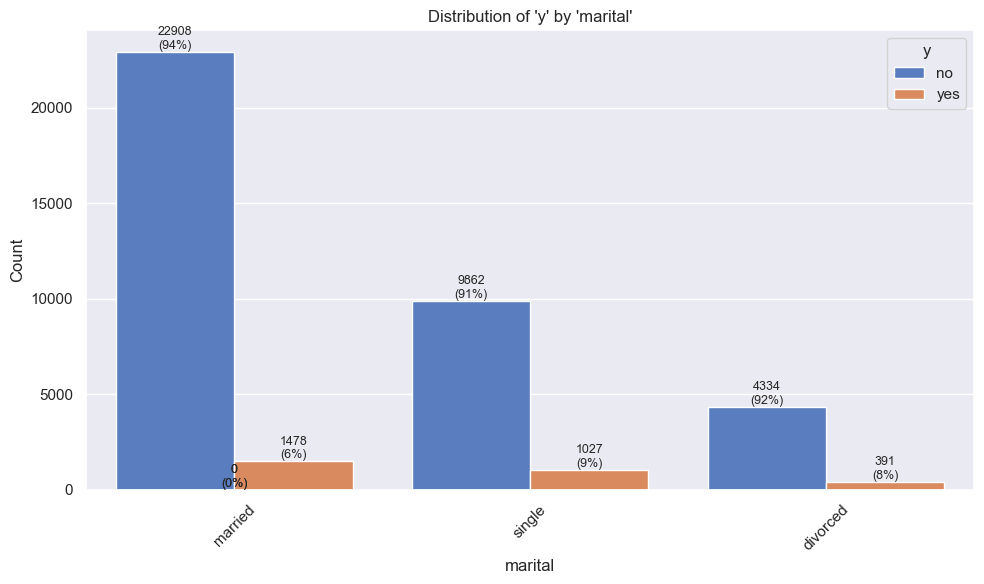

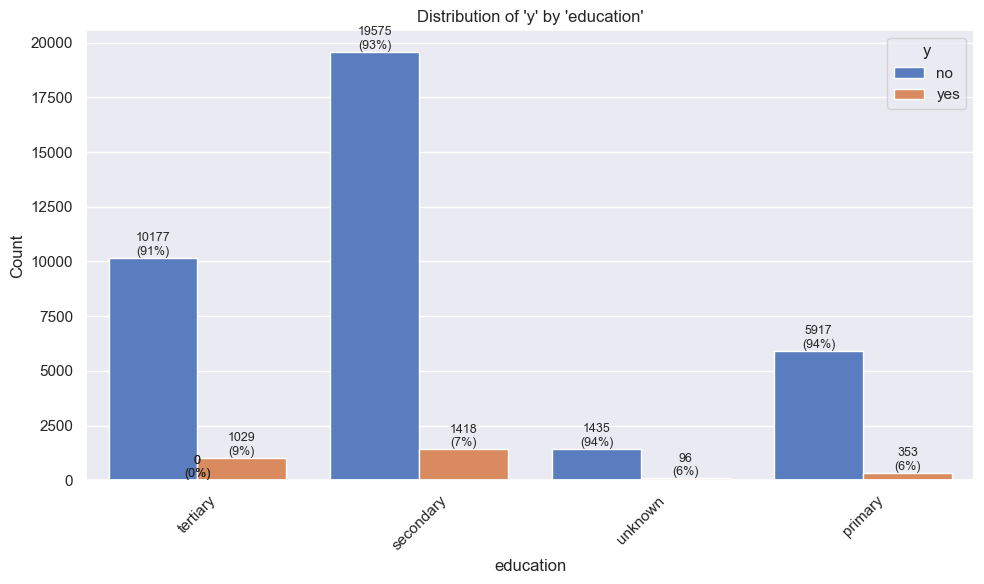

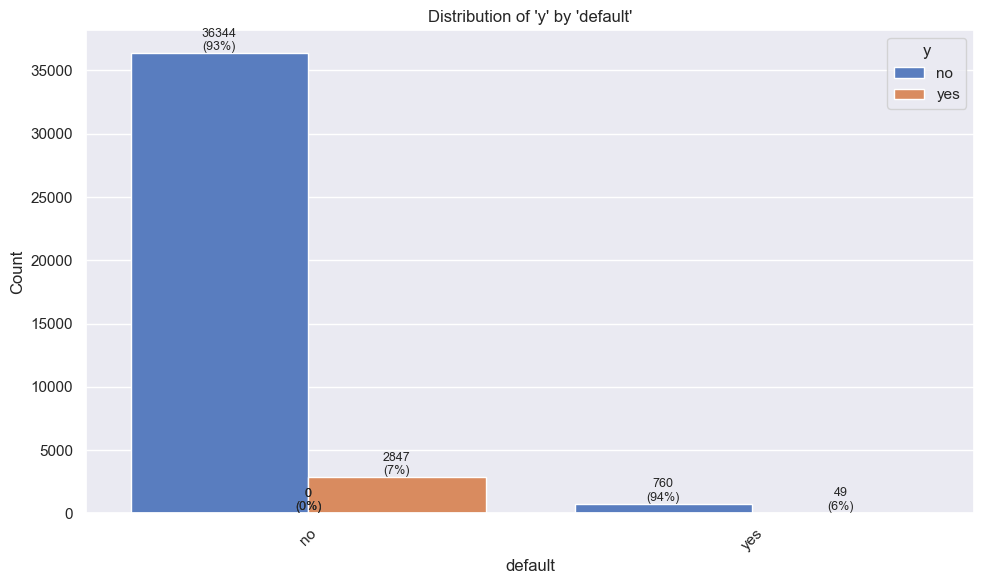

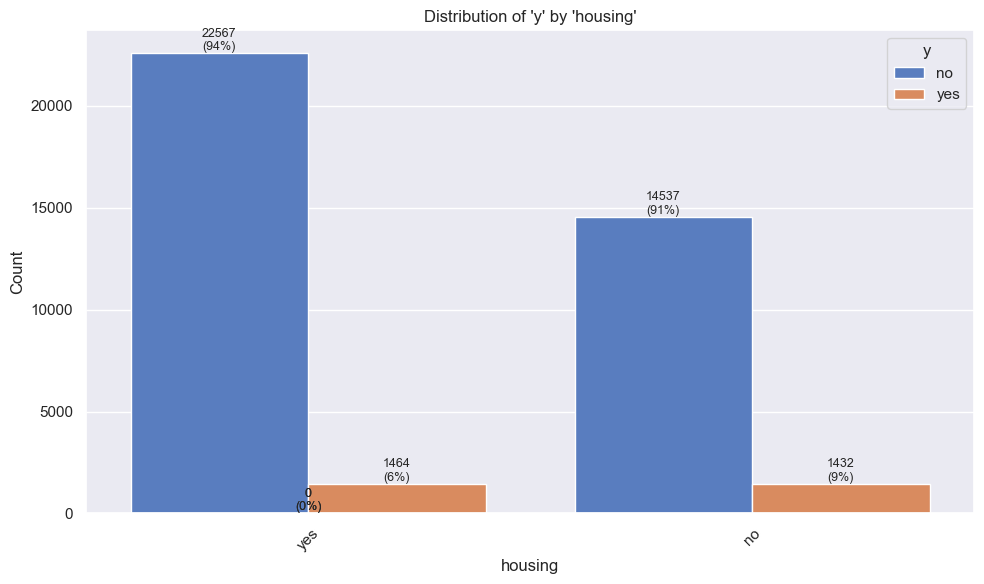

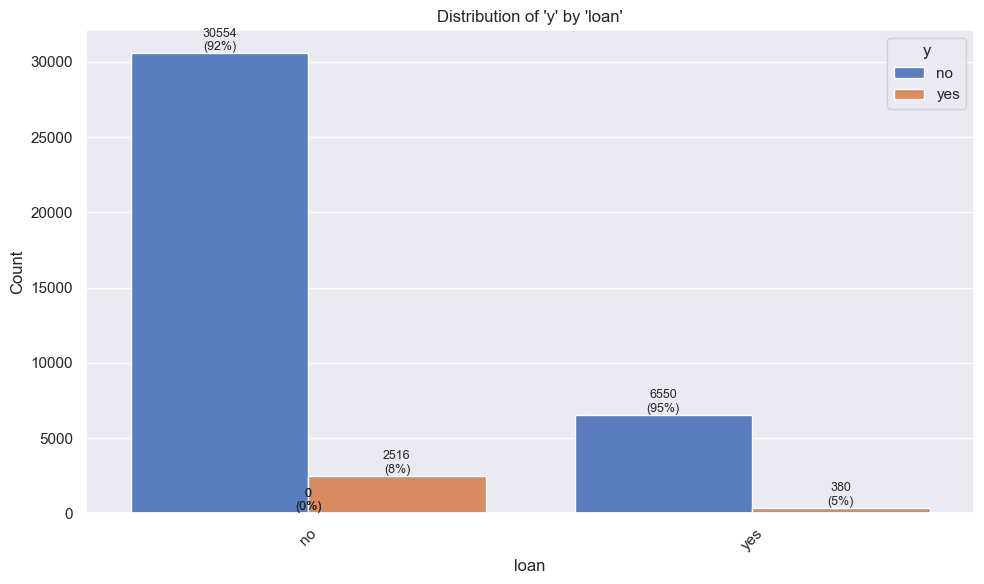

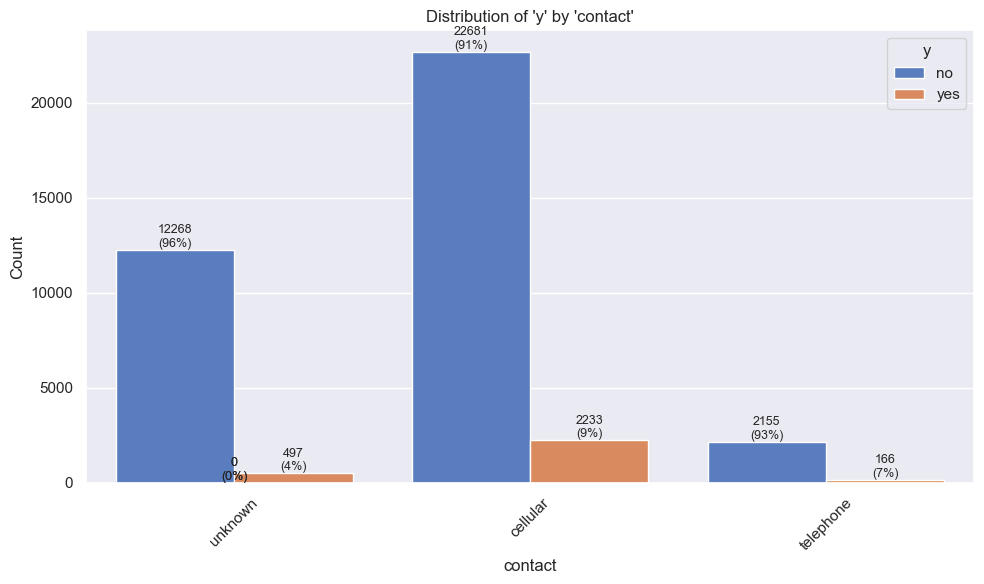

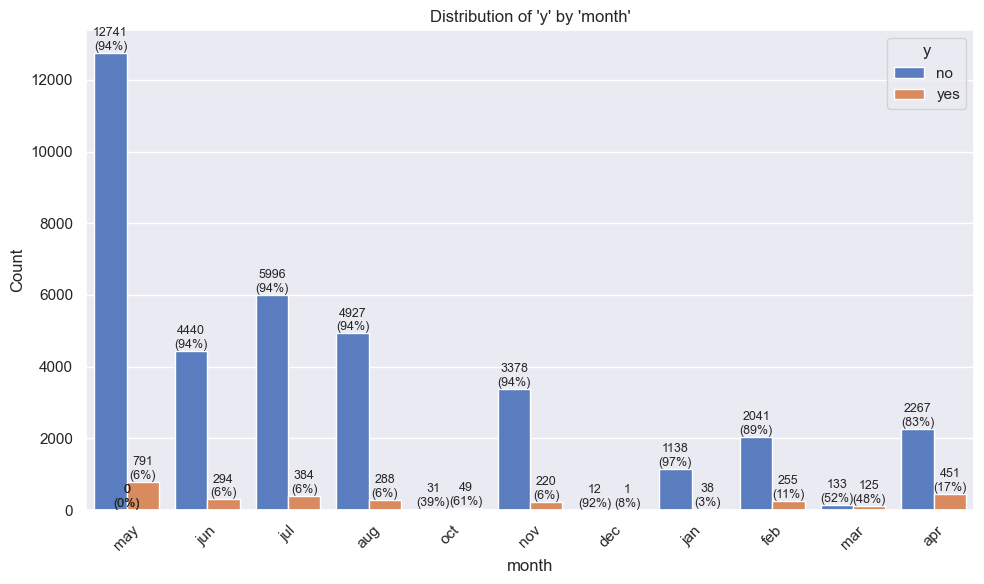

In [31]:
target_col = 'y'
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    ax = sb.countplot(data=df, x=var, hue=target_col, palette='muted')

    total_counts = df.groupby(var)[target_col].count()

    for p in ax.patches:
        height = int(p.get_height())
        x_val = p.get_x() + p.get_width() / 2.

        try:
            label_idx = int(round(p.get_x() + p.get_width() / 2.))
            category = ax.get_xticklabels()[label_idx].get_text()
        except:
            category = "?"

        total = total_counts.get(category, height)
        percent = (height / total) * 100 if total else 0

        ax.annotate(f'{height}\n({percent:.0f}%)',
                    (x_val, height),
                    ha='center', va='bottom', fontsize=9)

    plt.title(f"Distribution of '{target_col}' by '{var}'")
    plt.ylabel('Count')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Several bar charts were generated to compare categorical data against the target 'Y' value that we are seeking. Overall, there is a generally low acceptance rate throughout, but I will point out a few areas that are of interest based upon information from the categorical data:

   - The biggest 'yes' respondents based upon job type were students (16%) and retired (11%), no other categories showed 'yes' values that were in the double digits percentage-wise.
   - Individuals without housing were slightly more likely (9%) to accept than individuals without housing (6%)
   - Individuals without a loan (8%) were slightly more likely to say 'yes' than individuals with a loan (5%)
   - When categorizing by month, several interesting patterns appear:
        - October and March had some of the lowest overall responses, but the 'yes' answers were much higher
        - Only 4 months had 'yes' response percentages higher than 10% : October (61%), February (11%), March (48%), and April (17%)
        - The highest responses in a single month occurred in May with roughly a third of total responses occurring then

C:\Users\crozi\AppData\Local\Temp\ipykernel_45408\2284306040.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = df.groupby('age_bin')['y'].count()


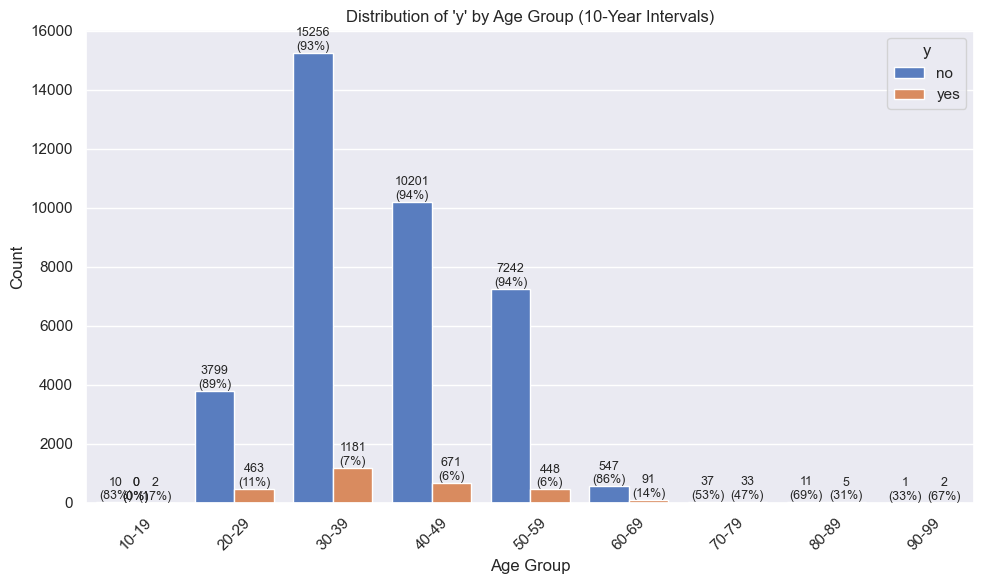

In [33]:
age_bins = list(range(10, 101, 10))
age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]

df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

total_counts = df.groupby('age_bin')['y'].count()

plt.figure(figsize=(10, 6))
ax = sb.countplot(data=df, x='age_bin', hue='y', palette='muted')

for p in ax.patches:
    height = int(p.get_height())
    x_val = p.get_x() + p.get_width() / 2.

    try:
        label_idx = int(round(p.get_x() + p.get_width() / 2.))
        category = ax.get_xticklabels()[label_idx].get_text()
    except:
        category = "?"

    total = total_counts.get(category, height)
    percent = (height / total) * 100 if total else 0

    ax.annotate(f'{height}\n({percent:.0f}%)',
                (x_val, height),
                ha='center', va='bottom', fontsize=9)

plt.title("Distribution of 'y' by Age Group (10-Year Intervals)")
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

By checking which subscribers are more likely to say yes and then looking at their age group, a small pattern emerges. While most of the answers for younger to middle age respondents are overwhelmingly 'no', it does show signs of a mild decline with younger responders slightly more likely to say 'yes' but that changes as they grow slightly older up until they hit 60 or above. While the responses from that group are much more limited, it shows that they are far more likely to say 'yes' then their much younger correspondents.

C:\Users\crozi\AppData\Local\Temp\ipykernel_45408\1797008200.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=filtered_df, x='y', y='balance', inner='box', palette='pastel')


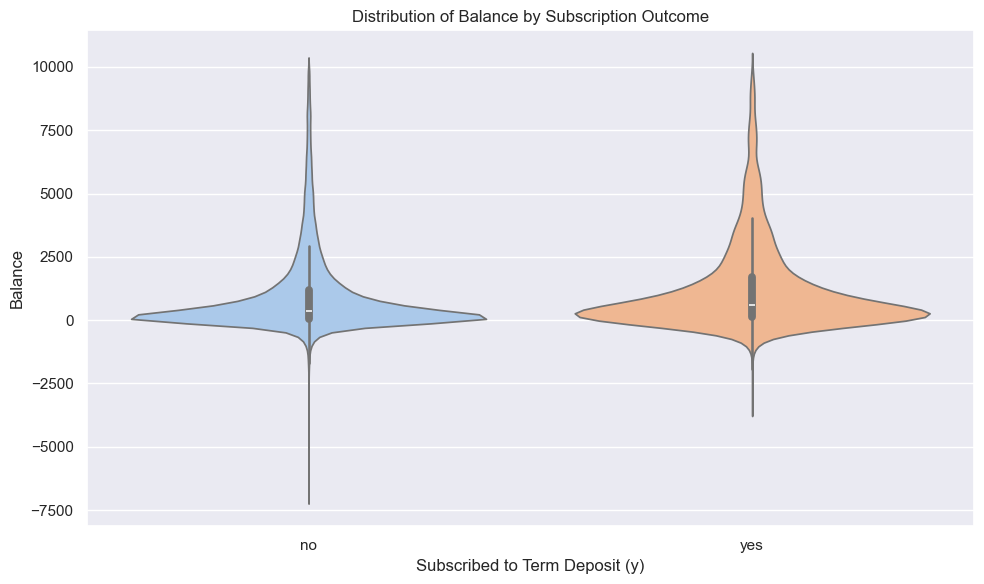

In [36]:
sb.set(style="darkgrid")

mean_balance = df['balance'].mean()
std_balance = df['balance'].std()
filtered_df = df[(df['balance'] >= (mean_balance - 3 * std_balance)) &
                 (df['balance'] <= (mean_balance + 3 * std_balance))]

plt.figure(figsize=(10, 6))
sb.violinplot(data=filtered_df, x='y', y='balance', inner='box', palette='pastel')
plt.title('Distribution of Balance by Subscription Outcome')
plt.xlabel('Subscribed to Term Deposit (y)')
plt.ylabel('Balance')
plt.tight_layout()
plt.show()

C:\Users\crozi\AppData\Local\Temp\ipykernel_45408\3055322763.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=df, x='y', y='duration', inner='box', palette='pastel')


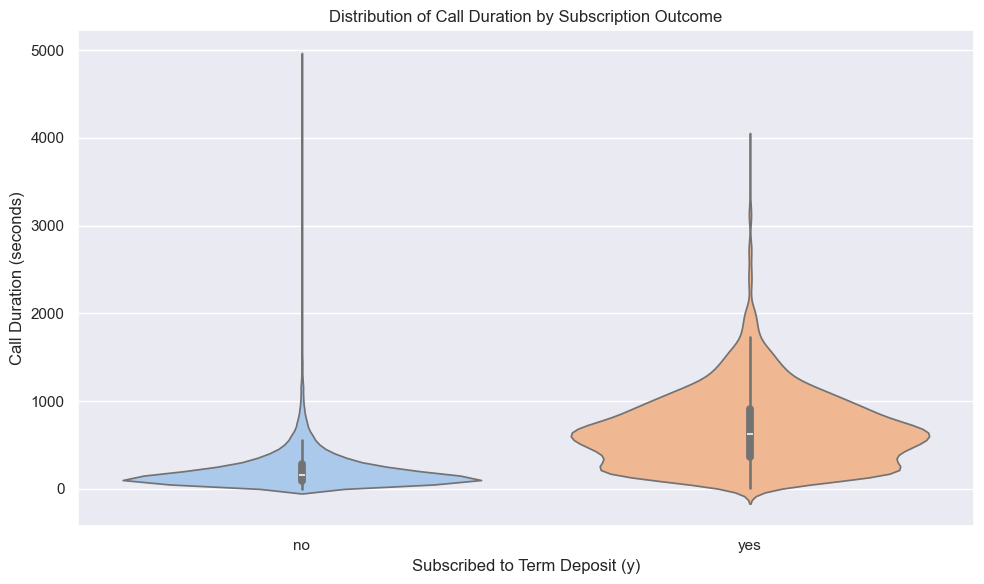

In [38]:
sb.set(style="darkgrid")

# Create a violin plot for duration
plt.figure(figsize=(10, 6))
sb.violinplot(data=df, x='y', y='duration', inner='box', palette='pastel')
plt.title('Distribution of Call Duration by Subscription Outcome')
plt.xlabel('Subscribed to Term Deposit (y)')
plt.ylabel('Call Duration (seconds)')
plt.tight_layout()
plt.show()

In [8]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = LazyClassifier()
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 32/32 [00:50<00:00,  1.58s/it]

[LightGBM] [Info] Number of positive: 1992, number of negative: 26008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.071143 -> initscore=-2.569265
[LightGBM] [Info] Start training from score -2.569265
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.88               0.79    None      0.90   
GaussianNB                         0.72               0.78    None      0.78   
LinearDiscriminantAnalysis         0.93               0.70    None      0.93   
DecisionTreeClassifier             0.91     

### Model Choices

While working on this project, a key issue that has been noted was that there was a massive unequal distribution between the subscribers for the 'y' variable. Of the 40,000 responses received, 37,104 signaled 'no' for the y variable while 2,896 gave a 'yes' response for the y variable. Having roughly 93% of the answers for the final variable of 'y' made it difficult to determine what might be initially convincing people to say yes during the marketing campaign. This also had another hidden problem, if we cannot determine the initial factors that would make someone say yes, we cannot eventually determine individuals who might say yes in a future marketing campaign. Using LazyClassifier, I was able to identify 3 models to use that had at least 90% for an f1 score, indicating a high degree of accuracy and performance for the models.

Three separate models were chosen, RandomForestClassifier, LinearDiscriminantAnalysis, and BaggingClassifier. They were chosen after using LazyClassifier to determine their f1 scores and accuracy which were suitably and may prove useful in helping determine why subscribers may say 'yes'. Since the goal of this project is to directly compare what the expected value of people who would say yes would fall under vs. the actual response rate, we will mostly focus on the precision of our 'yes' answers. When using RandomForestClassifier, the precision was measured at .33, with 658 'yes' actual answers against 1332 'no' answers that were predicted 'yes'. LinearDiscriminantAnalysis had 588 'yes' answers to 1103 'no' answers that were predicted as 'yes' for a precision score of .35. The BaggingClassifier model had 651 'yes' answers against 1286 'no' answers that were expected 'yes' for a precision score of .34. By reviewing the results and comparing them to the standard 8% 'yes' that can be extrapolated from the call center data sheet, we can begin looking further at the demographics and try to understand who is more likely to become a subscriber and what features may also make someone a subscriber in future campaigns.

In [4]:
df_filtered = df[df['campaign'] == 1]

X = df.drop(columns='y')
y = df['y'].map({'no': 0, 'yes': 1})
categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=seed)

desired_minority_train = sum(y_train == 1)
desired_majority_train = desired_minority_train

rus_train = RandomUnderSampler(
    sampling_strategy={0: desired_majority_train, 1: desired_minority_train},
    random_state=seed
)

X_train_bal, y_train_bal = rus_train.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

          no       0.99      0.86      0.92      9276
         yes       0.33      0.91      0.48       724

    accuracy                           0.86     10000
   macro avg       0.66      0.88      0.70     10000
weighted avg       0.94      0.86      0.89     10000



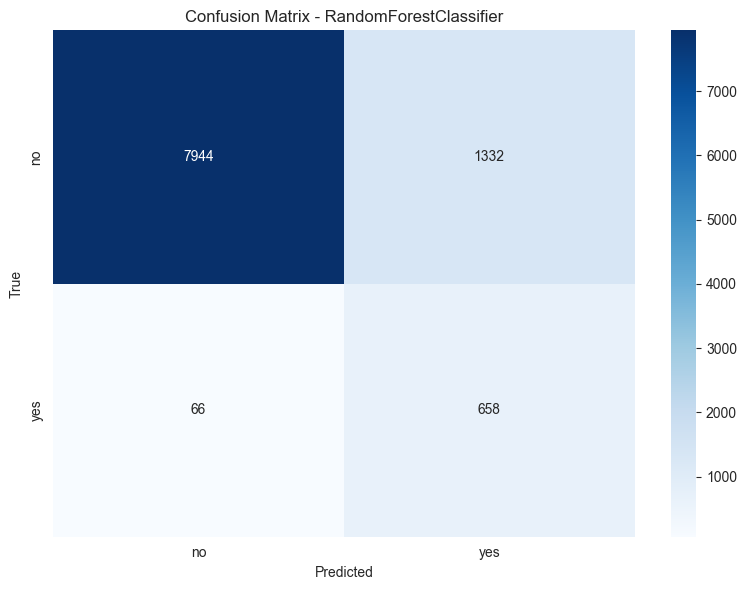

3187


In [8]:
clf = RandomForestClassifier(random_state=seed)
scoring = make_scorer(f1_score)
#cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=5, scoring=scoring)

#print("Cross-validation F1 scores:", cv_scores)
#print("Average F1 score:", cv_scores.mean())

clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - RandomForestClassifier')
plt.tight_layout()
plt.show()

print(seed)

              precision    recall  f1-score   support

          no       0.98      0.88      0.93      9276
         yes       0.35      0.81      0.49       724

    accuracy                           0.88     10000
   macro avg       0.67      0.85      0.71     10000
weighted avg       0.94      0.88      0.90     10000



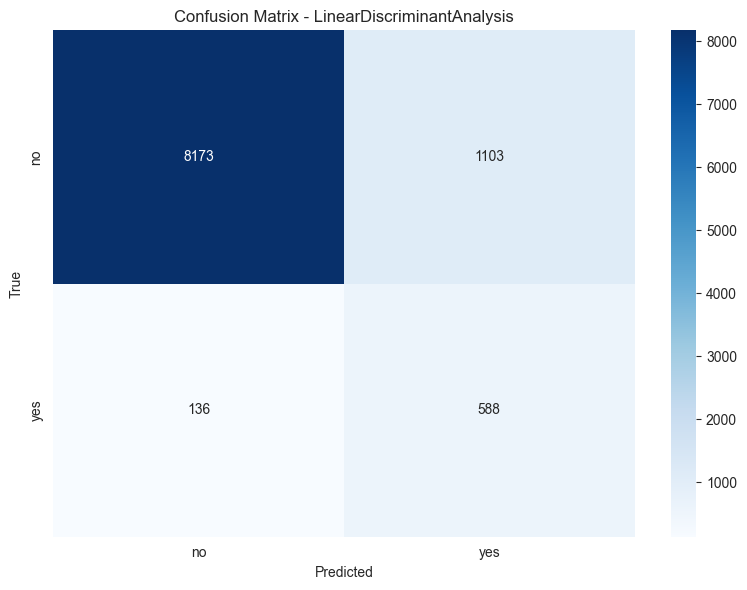

In [9]:
X_train_bal = X_train_bal.toarray() if hasattr(X_train_bal, "toarray") else X_train_bal
X_test = X_test.toarray() if hasattr(X_test, "toarray") else X_test

clf = LinearDiscriminantAnalysis()
scoring = make_scorer(f1_score)
#cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=5, scoring=scoring)

#print("Cross-validation F1 scores:", cv_scores)
#print("Average F1 score:", cv_scores.mean())

clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LinearDiscriminantAnalysis')
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

          no       0.99      0.86      0.92      9276
         yes       0.33      0.90      0.48       724

    accuracy                           0.86     10000
   macro avg       0.66      0.88      0.70     10000
weighted avg       0.94      0.86      0.89     10000



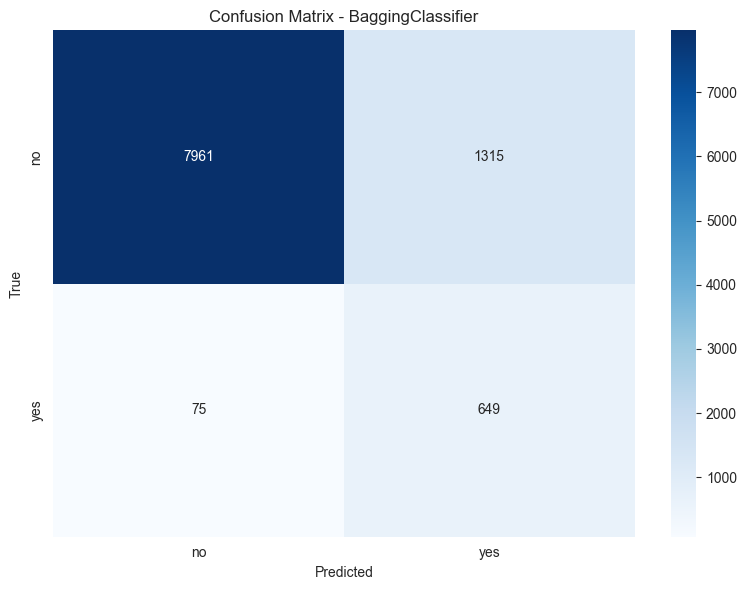

3187


In [10]:
clf = BaggingClassifier()
scoring = make_scorer(f1_score)
#cv_scores = cross_val_score(clf, X_train_bal, y_train_bal, cv=5, scoring=scoring)

#print("Cross-validation F1 scores:", cv_scores)
#print("Average F1 score:", cv_scores.mean())

clf.fit(X_train_bal, y_train_bal)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - BaggingClassifier')
plt.tight_layout()
plt.show()

print(seed)

### Reviewing Data after the First Campaign

One of the biggest things that needed to be done was look at the data again following the first campaign. By doing so, we can draw conclusions about who was most likely to respond with 'yes' given a feature value against someone more likely to respond with a 'no' to a feature value. By separating the features and examining them closely for the first campaign, we can develop an understanding of key influencers that might make someone more likely to say yes, for example:

- Individuals between 65-75 were more likely to say yes than no, and older individuals were more likely to say yes in general than younger individuals
- Balance had a bit of a minimal impact on whether a subscriber said yes or no, but anyone with an account balance over $50000 would not say yes
- When looking at individual jobs there were several job types who were more likely to say yes than no, they include: admin, management, retired, self-employed, student, technician, and unemployed
- When looking at marital data, single or divorced individuals were more likely to say yes than those currently married.
- When looking at education data, individuals with just a primary education or an unknown were more likely to say no, individuals with a secondary education were almost tied with no answers only slightly higher than yes answers, and individuals with a tertiary education were more likely to say yes than no
- Respondents without housing were more likely to say 'yes' than respondents who had housing
- Respondents who had a loan were more likely to say 'yes' than respondents without one
- Respondents contacted by cellular or telephone were slightly more likely to say 'yes'
- Several months were associated with higher 'yes' responses, they include: April, February, March, and October

With this knowledge, we have a slightly better idea of who is likely to say 'yes' during an initial campaign. With this knowledge, we now test again in future campaigns to see if a pattern emerges and if the higher 'yes' responses for certain features holds true for future campaigns.

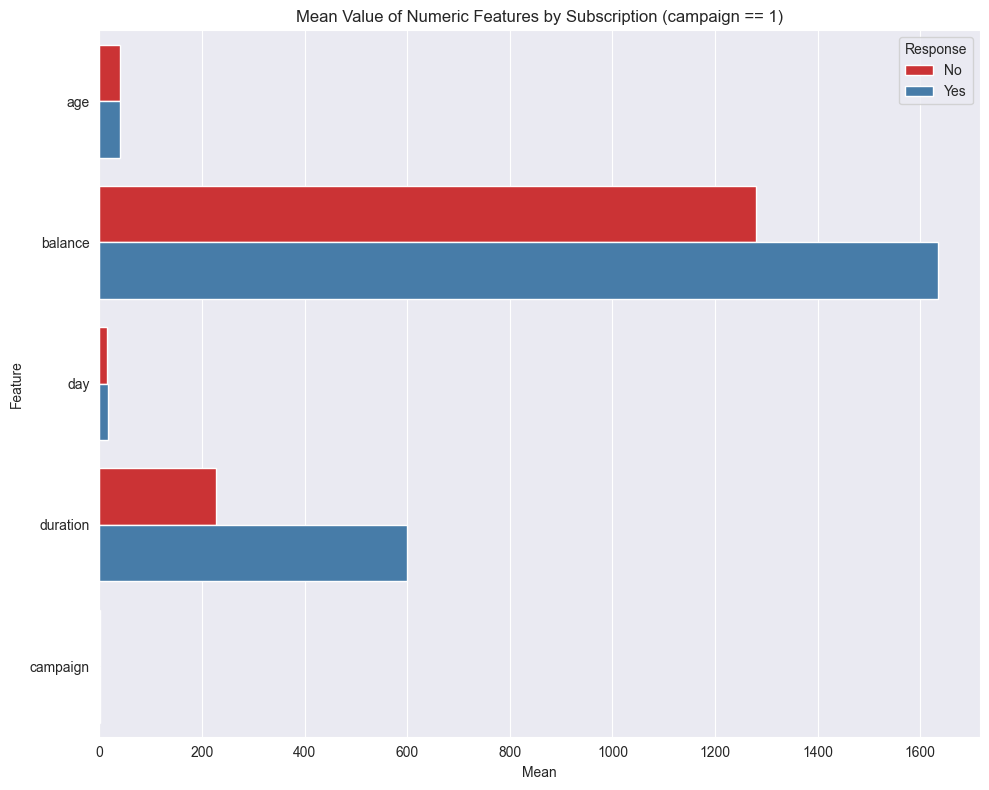

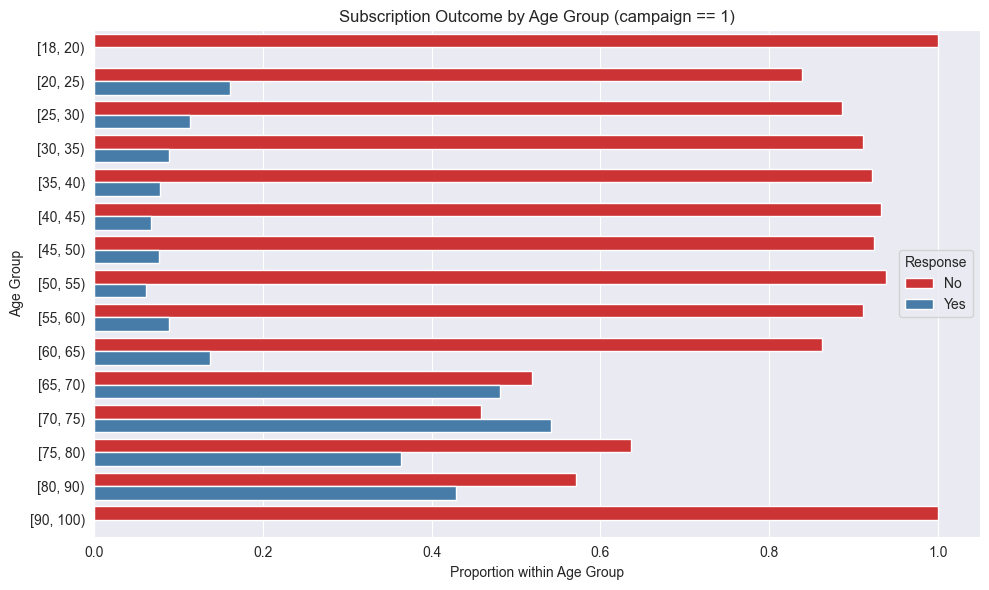

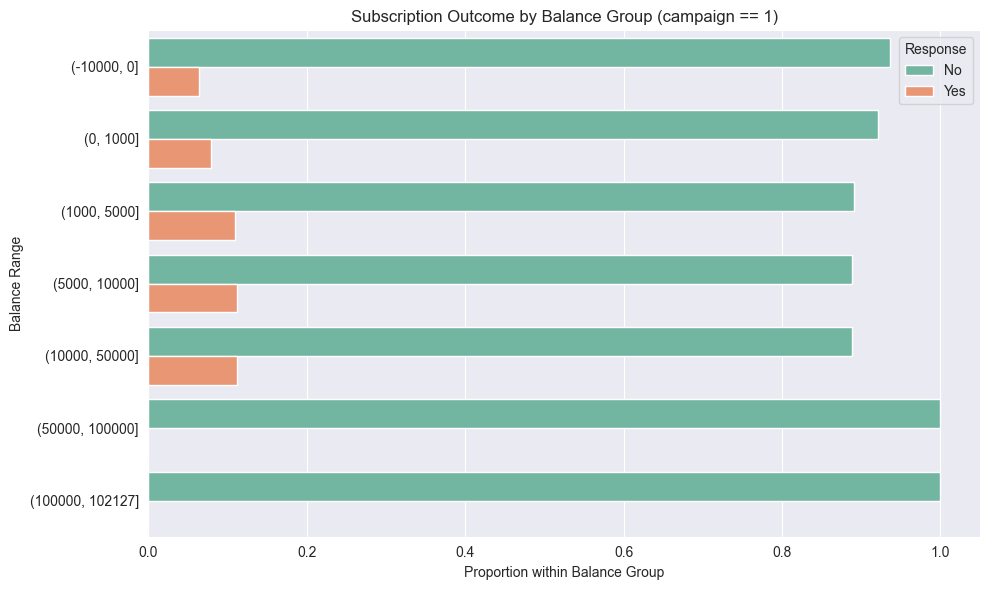

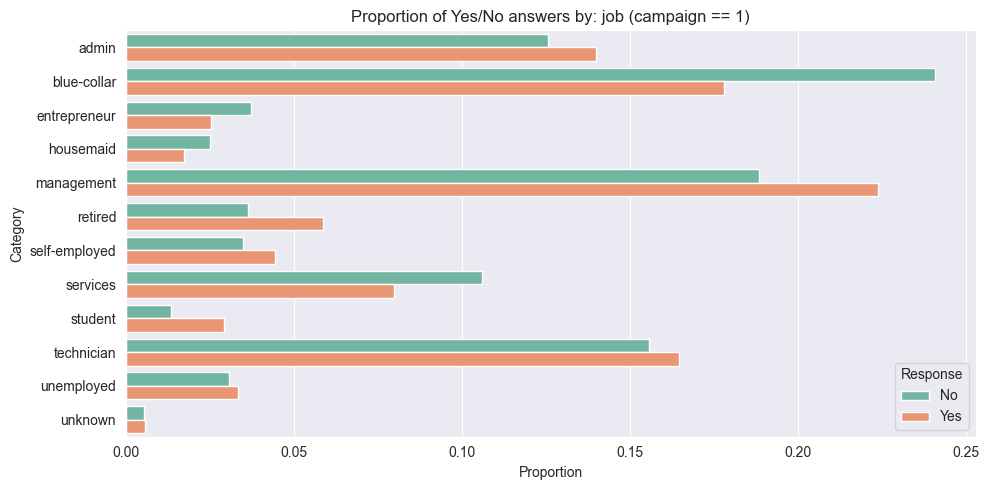

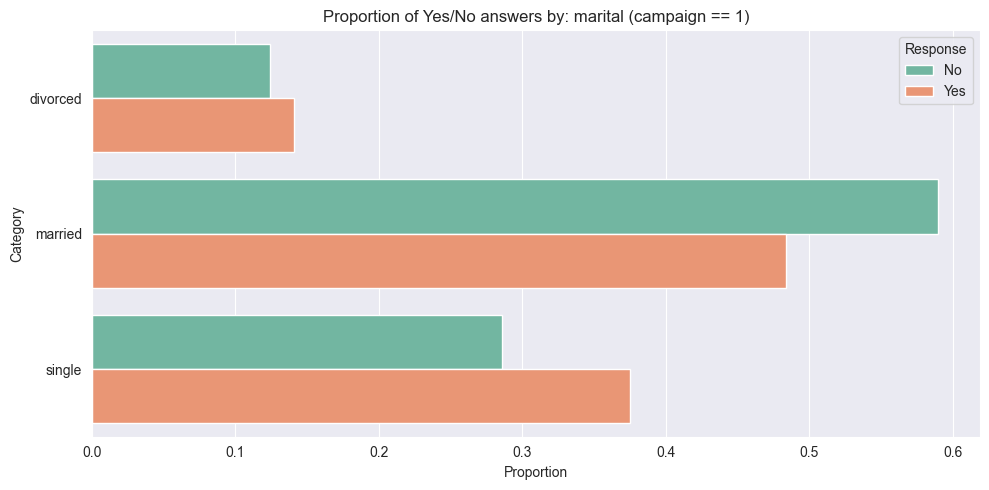

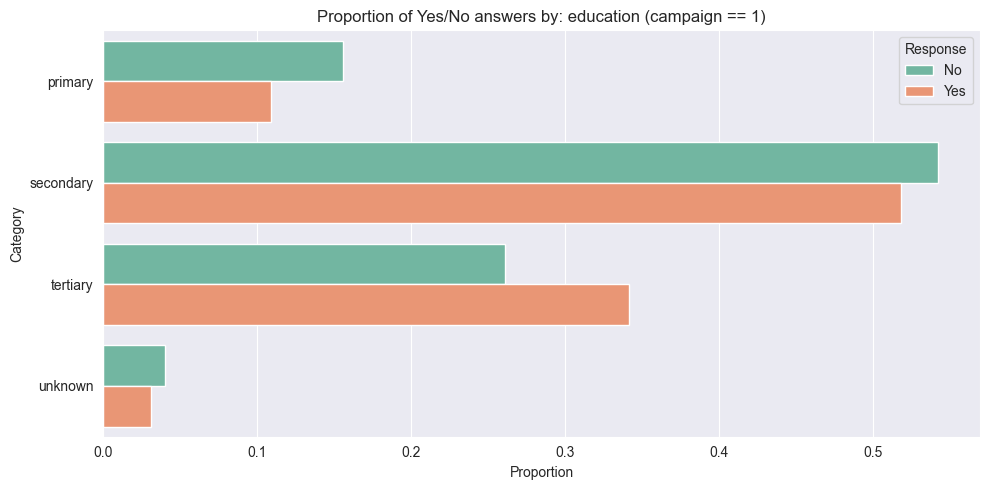

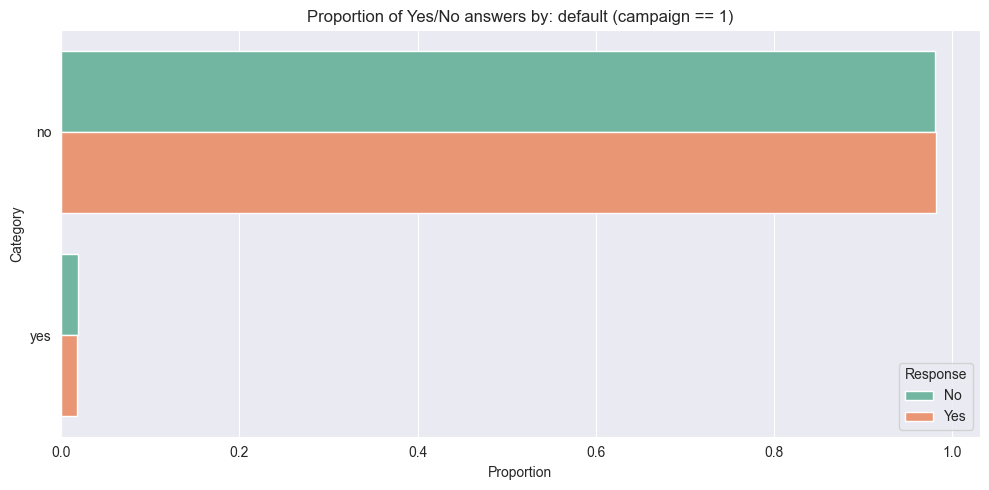

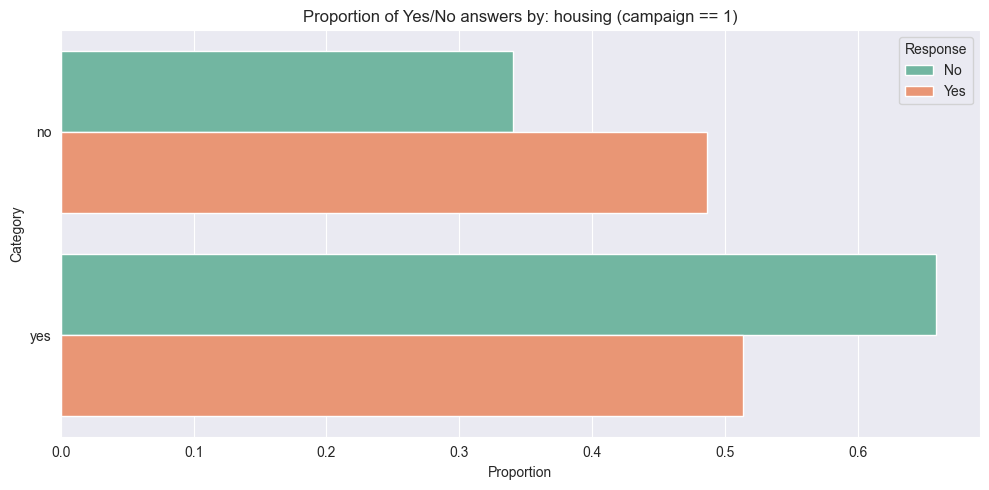

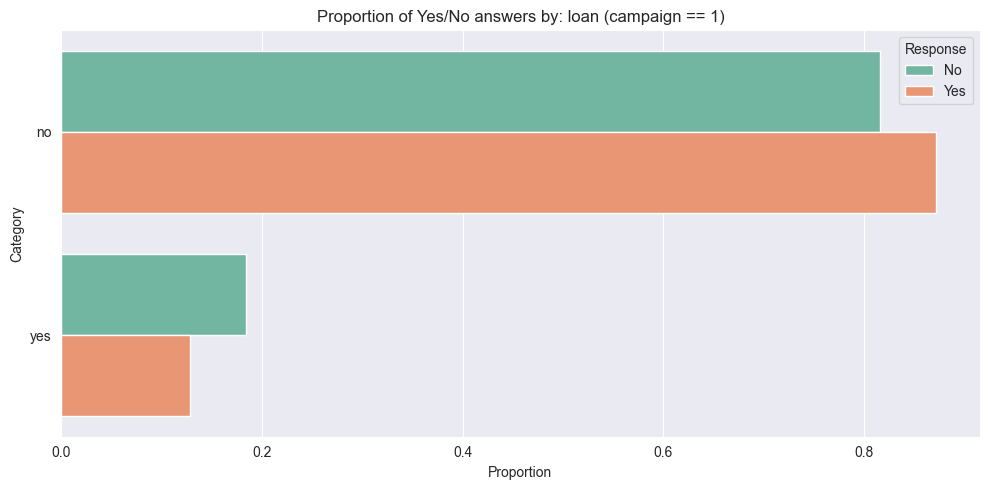

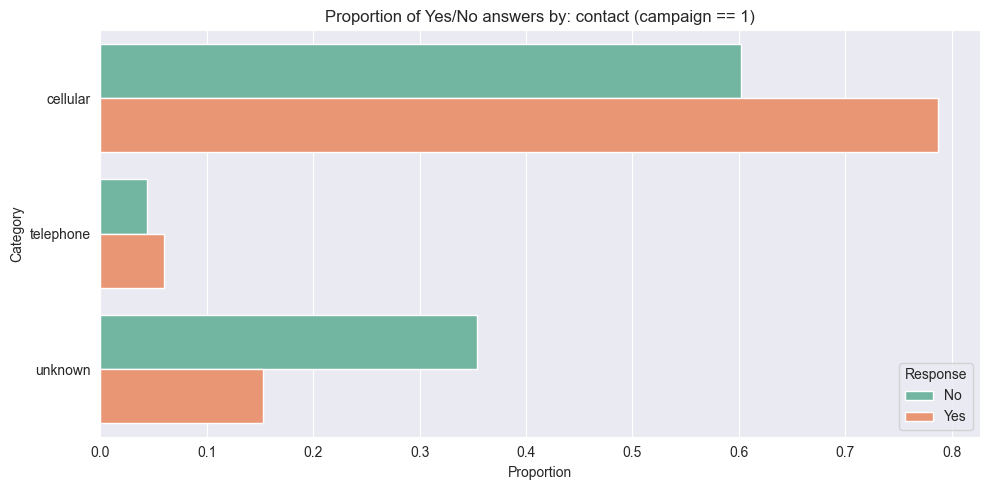

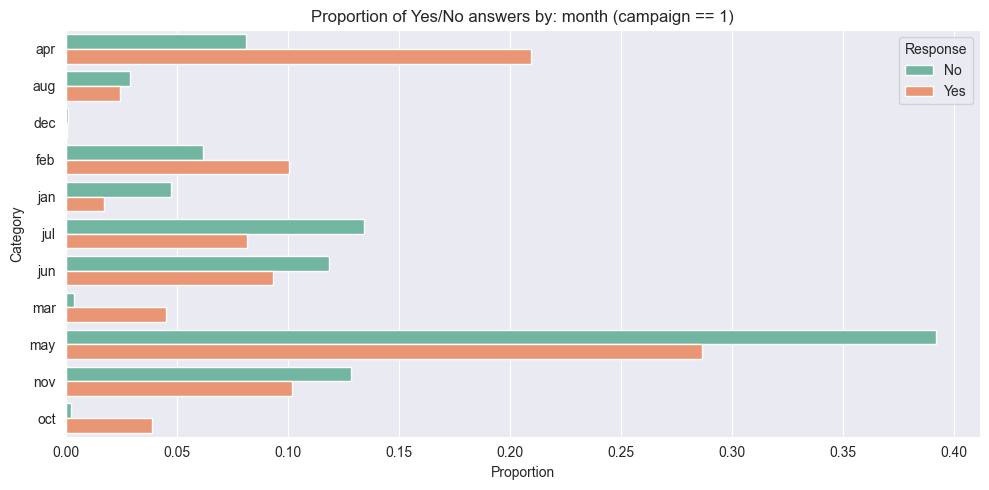

In [26]:
df_filtered = df[df['campaign'] == 1].copy()
df_filtered['y'] = df_filtered['y'].map({'no': 0, 'yes': 1})

numeric_cols = df_filtered.select_dtypes(include=['int64', 'float64']).drop(columns='y').columns
categorical_cols = df_filtered.select_dtypes(include='object').columns

num_grouped = df_filtered.groupby('y')[numeric_cols].mean().T
num_grouped.columns = ['No', 'Yes']
num_grouped = num_grouped.reset_index().rename(columns={'index': 'Feature'})
num_melted = num_grouped.melt(id_vars='Feature', var_name='Response', value_name='Mean')

plt.figure(figsize=(10, 8))
sb.barplot(data=num_melted, y='Feature', x='Mean', hue='Response', palette='Set1')
plt.title('Mean Value of Numeric Features by Subscription (campaign == 1)')
plt.tight_layout()
plt.show()

age_bins = [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, right=False)

age_ct = pd.crosstab(df_filtered['age_group'], df_filtered['y'], normalize='index')
age_ct.columns = ['No', 'Yes']
age_ct = age_ct.reset_index().melt(id_vars='age_group', var_name='Response', value_name='Proportion')

plt.figure(figsize=(10, 6))
sb.barplot(data=age_ct, x='Proportion', y='age_group', hue='Response', palette='Set1')
plt.title('Subscription Outcome by Age Group (campaign == 1)')
plt.xlabel('Proportion within Age Group')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

balance_bins = [-10000, 0, 1000, 5000, 10000, 50000, 100000, df_filtered['balance'].max()]
df_filtered['balance_group'] = pd.cut(df_filtered['balance'], bins=balance_bins)

balance_ct = pd.crosstab(df_filtered['balance_group'], df_filtered['y'], normalize='index')
balance_ct.columns = ['No', 'Yes']
balance_ct = balance_ct.reset_index().melt(id_vars='balance_group', var_name='Response', value_name='Proportion')

plt.figure(figsize=(10, 6))
sb.barplot(data=balance_ct, x='Proportion', y='balance_group', hue='Response', palette='Set2')
plt.title('Subscription Outcome by Balance Group (campaign == 1)')
plt.xlabel('Proportion within Balance Group')
plt.ylabel('Balance Range')
plt.tight_layout()
plt.show()

cat_data = []

for col in categorical_cols:
    # Cross-tabulate category vs y
    cat_counts = pd.crosstab(df_filtered[col], df_filtered['y'], normalize='columns')  # Normalize to get proportions
    for category in cat_counts.index:
        cat_data.append({
            'Feature': col,
            'Category': category,
            'No': cat_counts.loc[category, 0],
            'Yes': cat_counts.loc[category, 1]
        })

cat_df = pd.DataFrame(cat_data)
cat_melted = cat_df.melt(id_vars=['Feature', 'Category'], value_vars=['No', 'Yes'], var_name='Response', value_name='Proportion')
unique_features = cat_melted['Feature'].unique()

for feat in unique_features:
    subset = cat_melted[cat_melted['Feature'] == feat]
    plt.figure(figsize=(10, 5))
    sb.barplot(data=subset, x='Proportion', y='Category', hue='Response', palette='Set2')
    plt.title(f'Proportion of Yes/No answers by: {feat} (campaign == 1)')
    plt.tight_layout()
    plt.show()

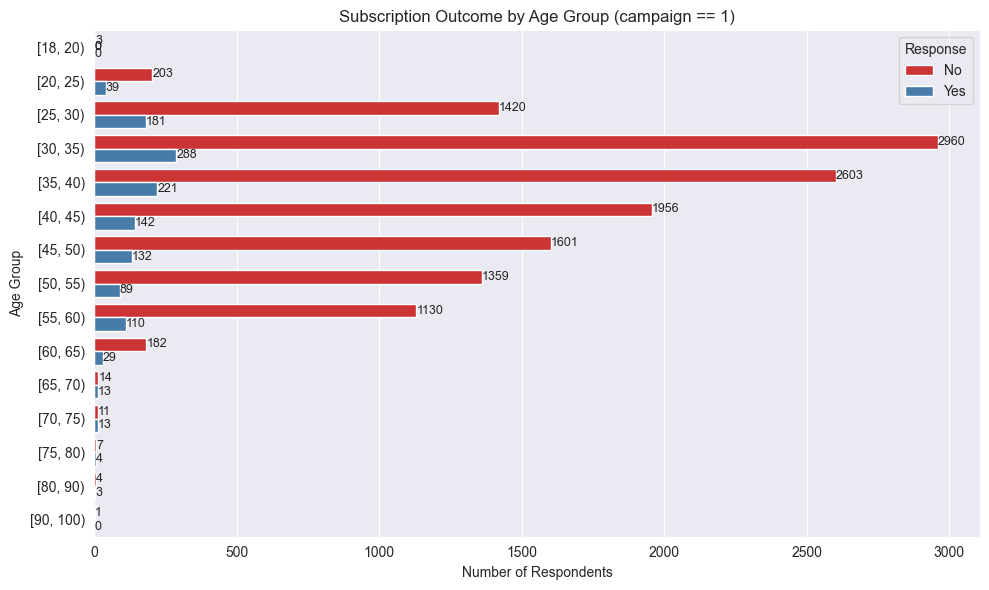

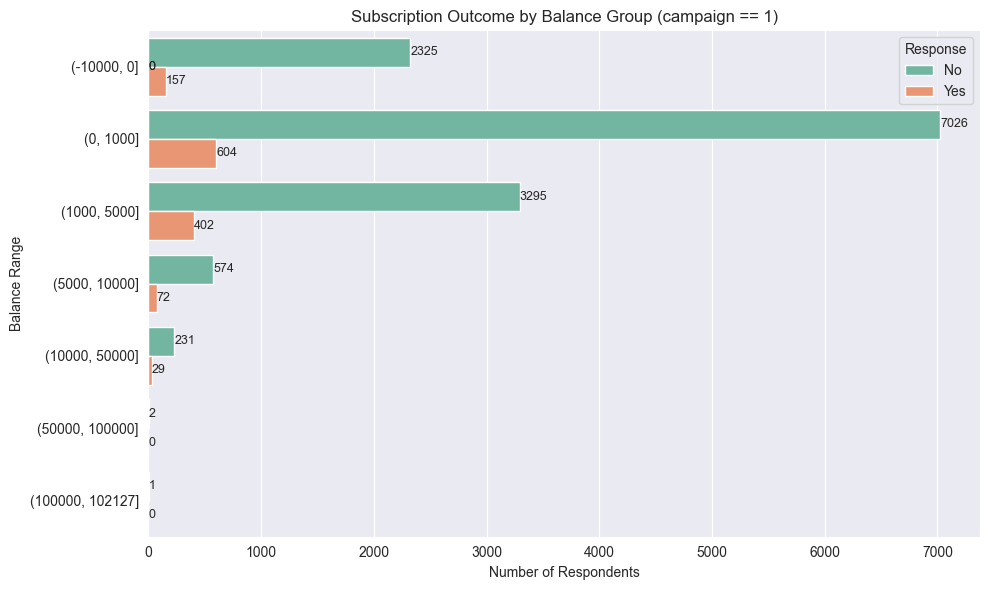

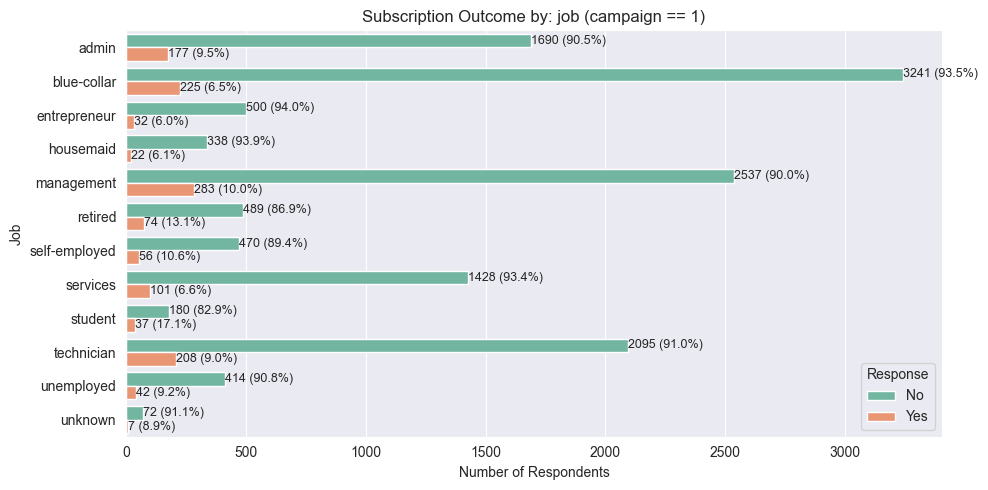

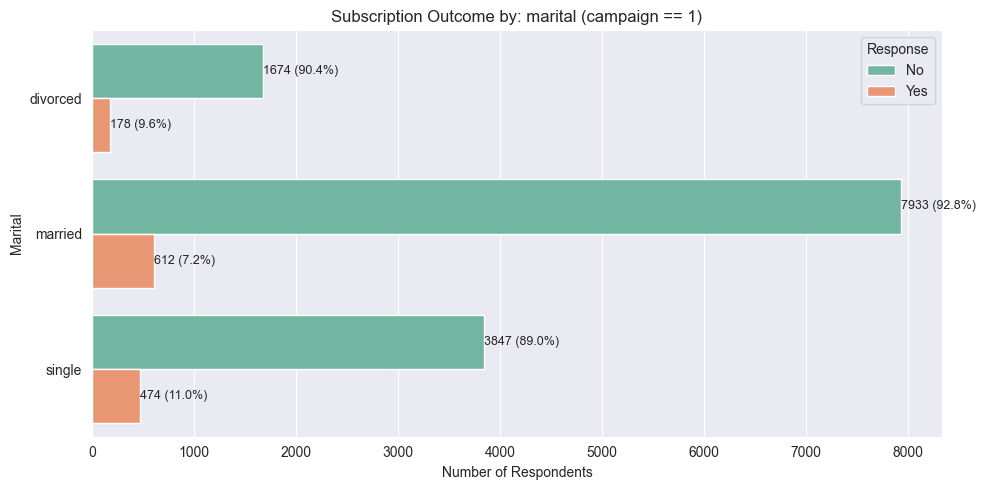

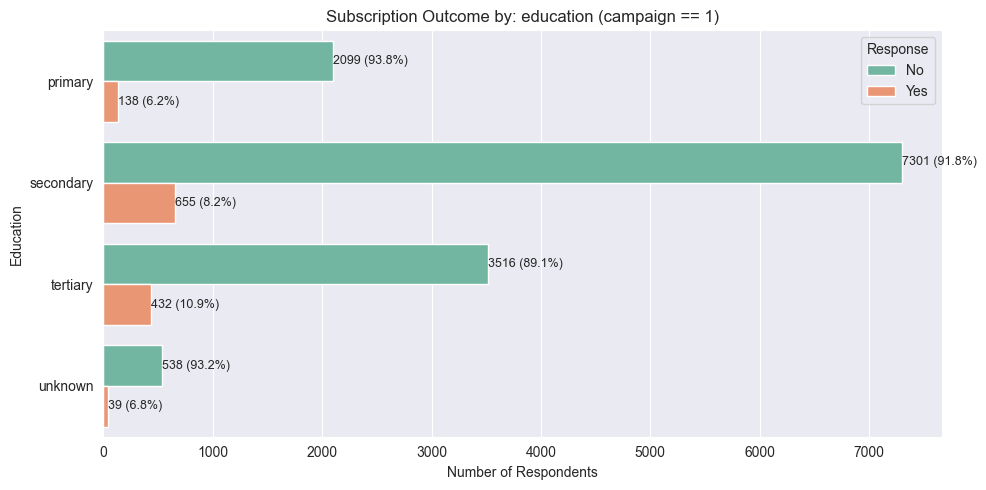

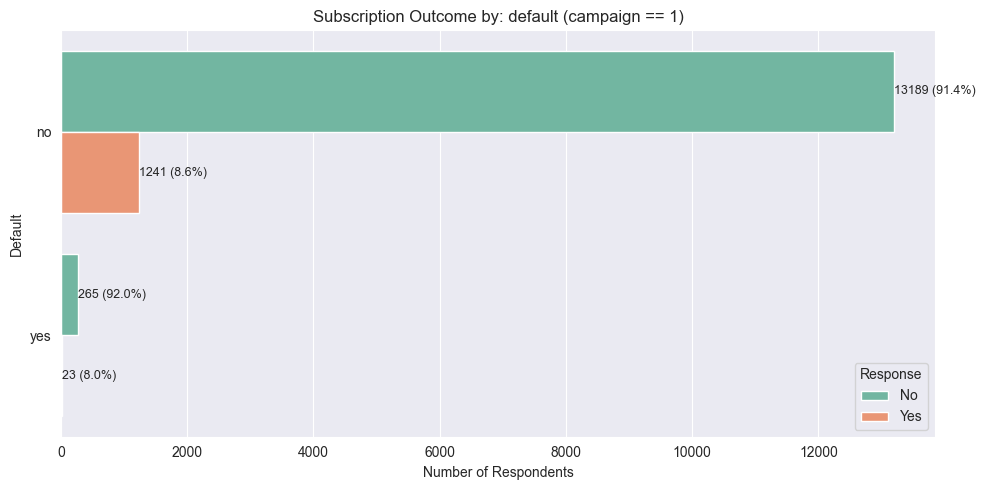

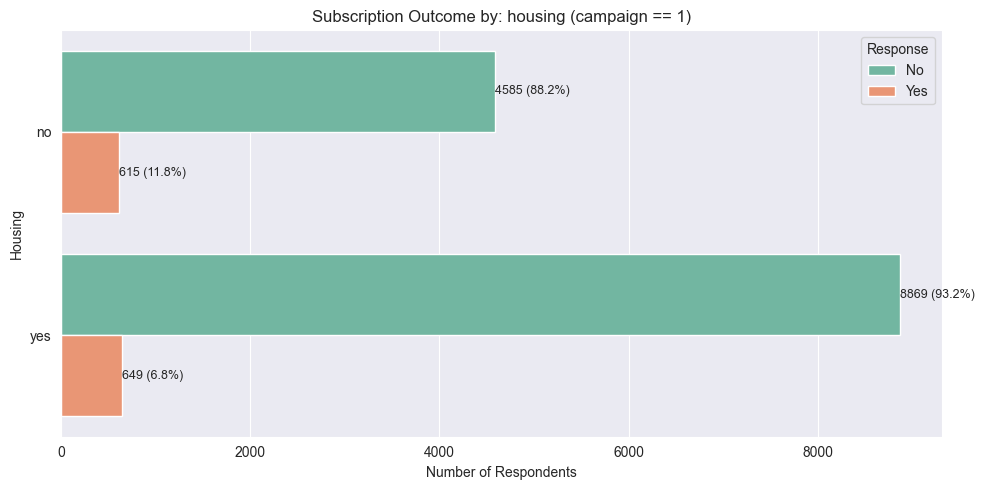

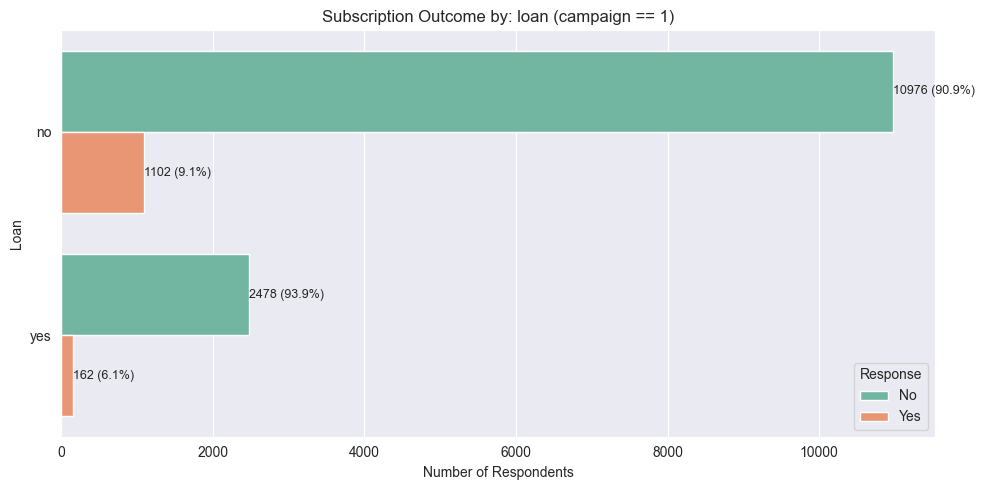

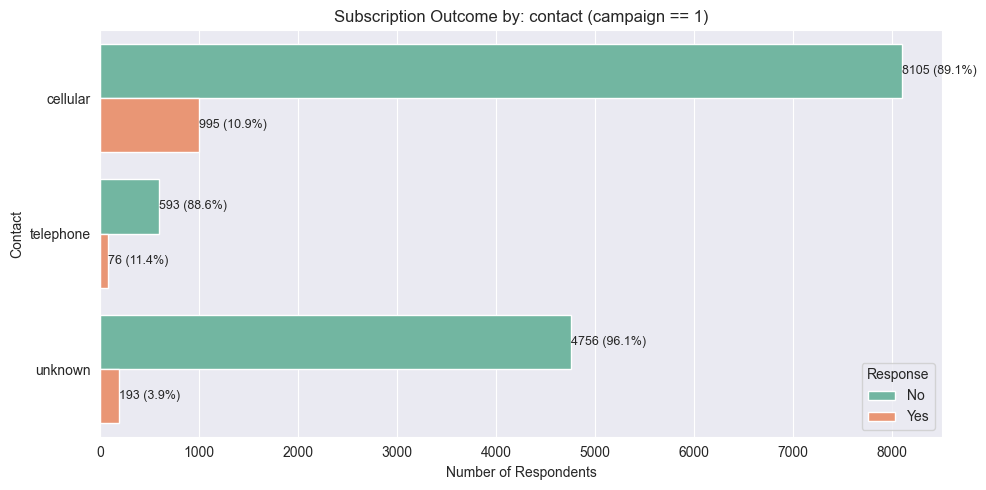

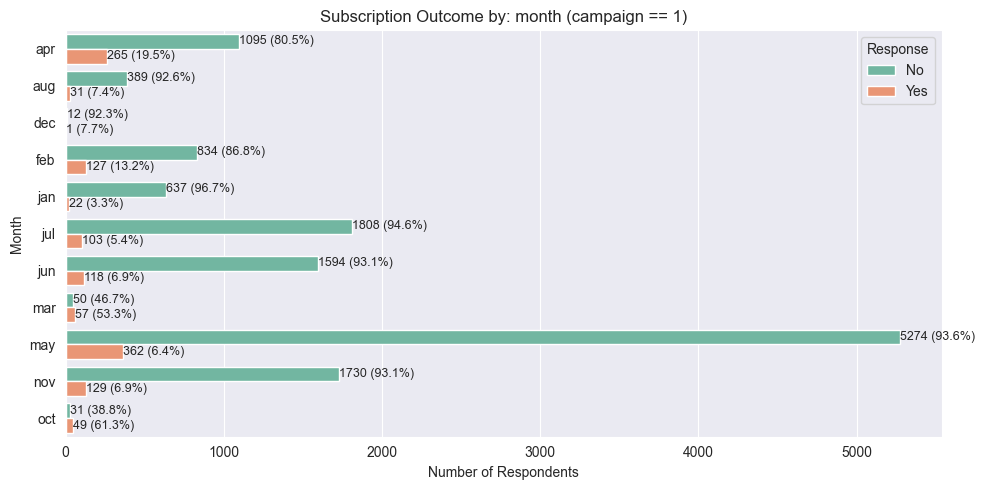

In [15]:
df_filtered = df[df['campaign'] == 1].copy()
df_filtered['y'] = df_filtered['y'].map({'no': 0, 'yes': 1})

age_bins = [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, right=False)

age_ct = pd.crosstab(df_filtered['age_group'], df_filtered['y'])
age_long = age_ct.reset_index().melt(id_vars='age_group', var_name='Response', value_name='Count')
age_long['Response'] = age_long['Response'].map({0: 'No', 1: 'Yes'})
totals_age = age_long.groupby('age_group')['Count'].sum().rename('Total')
age_long = age_long.merge(totals_age, on='age_group')
age_long['Percentage'] = (age_long['Count'] / age_long['Total']) * 100

plt.figure(figsize=(10, 6))
ax = sb.barplot(data=age_long, x='Count', y='age_group', hue='Response', palette='Set1')
for bar in ax.patches:
    count = int(bar.get_width())
    bar_center_y = bar.get_y() + bar.get_height() / 2
    label = f'{count}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width(), bar_center_y),
                ha='left', va='center', fontsize=9)
plt.title('Subscription Outcome by Age Group (campaign == 1)')
plt.xlabel('Number of Respondents')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

balance_bins = [-10000, 0, 1000, 5000, 10000, 50000, 100000, df_filtered['balance'].max()]
df_filtered['balance_group'] = pd.cut(df_filtered['balance'], bins=balance_bins)

balance_ct = pd.crosstab(df_filtered['balance_group'], df_filtered['y'])
balance_long = balance_ct.reset_index().melt(id_vars='balance_group', var_name='Response', value_name='Count')
balance_long['Response'] = balance_long['Response'].map({0: 'No', 1: 'Yes'})
totals_balance = balance_long.groupby('balance_group')['Count'].sum().rename('Total')
balance_long = balance_long.merge(totals_balance, on='balance_group')
balance_long['Percentage'] = (balance_long['Count'] / balance_long['Total']) * 100

plt.figure(figsize=(10, 6))
ax = sb.barplot(data=balance_long, x='Count', y='balance_group', hue='Response', palette='Set2')
for bar in ax.patches:
    count = int(bar.get_width())
    bar_center_y = bar.get_y() + bar.get_height() / 2
    label = f'{count}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width(), bar_center_y),
                ha='left', va='center', fontsize=9)
plt.title('Subscription Outcome by Balance Group (campaign == 1)')
plt.xlabel('Number of Respondents')
plt.ylabel('Balance Range')
plt.tight_layout()
plt.show()

categorical_cols = df_filtered.select_dtypes(include='object').columns

def annotate_bars_using_labels(ax, data, group_col):
    yticklabels = [tick.get_text() for tick in ax.get_yticklabels()]
    for bar in ax.patches:
        bar_center_y = bar.get_y() + bar.get_height() / 2
        closest_tick_index = int(round(bar_center_y))
        if 0 <= closest_tick_index < len(yticklabels):
            category = yticklabels[closest_tick_index]
            count = int(bar.get_width())
            match = data[(data[group_col] == category) & (data['Count'] == count)]
            if not match.empty:
                pct = match['Percentage'].values[0]
                label = f'{count} ({pct:.1f}%)'
                ax.annotate(label,
                            xy=(bar.get_x() + bar.get_width(), bar.get_y() + bar.get_height() / 2),
                            ha='left', va='center', fontsize=9)

def generate_chart_with_annotations(col):
    cat_counts = pd.crosstab(df_filtered[col], df_filtered['y'])
    cat_long = cat_counts.reset_index().melt(id_vars=col, var_name='Response', value_name='Count')
    cat_long['Response'] = cat_long['Response'].map({0: 'No', 1: 'Yes'})
    totals = cat_long.groupby(col)['Count'].sum().rename('Total')
    cat_long = cat_long.merge(totals, on=col)
    cat_long['Percentage'] = (cat_long['Count'] / cat_long['Total']) * 100

    plt.figure(figsize=(10, 5))
    ax = sb.barplot(data=cat_long, x='Count', y=col, hue='Response', palette='Set2')
    annotate_bars_using_labels(ax, cat_long, col)
    plt.title(f'Subscription Outcome by: {col} (campaign == 1)')
    plt.xlabel('Number of Respondents')
    plt.ylabel(col.capitalize())
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    generate_chart_with_annotations(col)

### Data Review after Future Campaigns

By setting up to filter and reviewing campaign data from all campaigns that were 2 or greater, we can identify who was likely to say 'yes' based on the data and use that to help determine who did respond with a yes in the future.

- Younger individuals were slightly more likely to say but as they got slightly older that number dropped. However, it did rise again for individuals older than 65. But it did not become more likely for them to say 'yes', it became more likely for their response to be split down the middle
- Results were slightly similar for the first campaign, where balance had a minimal overall impact but individuals with an account of $50000 or over were unlikely to say 'yes'
- Respondents jobs showed a similar pattern in subsequent campaigns as in the initial, where respondents involved in admin, management, retired, student, unemployed
- Respondents whose marital status was listed as divorced or single were more likely to say 'yes' than respondents who listed themselves as married
- Similar to the results when the campaign was listed as 1, individuals who had a tertiary education were more likely to say 'yes' than the other respondents
- Similar to the results when the campaign was listed as 1, individuals without housing were more likely to say 'yes' than individuals who currently had housing

In [6]:
df_filtered = df[df['campaign'] >= 2]

X = df.drop(columns='y')
y = df['y'].map({'no': 0, 'yes': 1})
categorical_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

X_encoded = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=seed)

desired_minority_test = sum(y_test == 1)
desired_majority_test = desired_minority_test  # For 1:1 ratio

rus_test = RandomUnderSampler(
    sampling_strategy={0: desired_majority_test, 1: desired_minority_test},
    random_state=seed
)
X_test_bal, y_test_bal = rus_test.fit_resample(X_test, y_test)

print(Counter(y_test_bal))

desired_minority_train = sum(y_train == 1)
desired_majority_train = desired_minority_train

rus_train = RandomUnderSampler(
    sampling_strategy={0: desired_majority_train, 1: desired_minority_train},
    random_state=seed
)
X_train_bal, y_train_bal = rus_train.fit_resample(X_train, y_train)

Counter({0: 724, 1: 724})


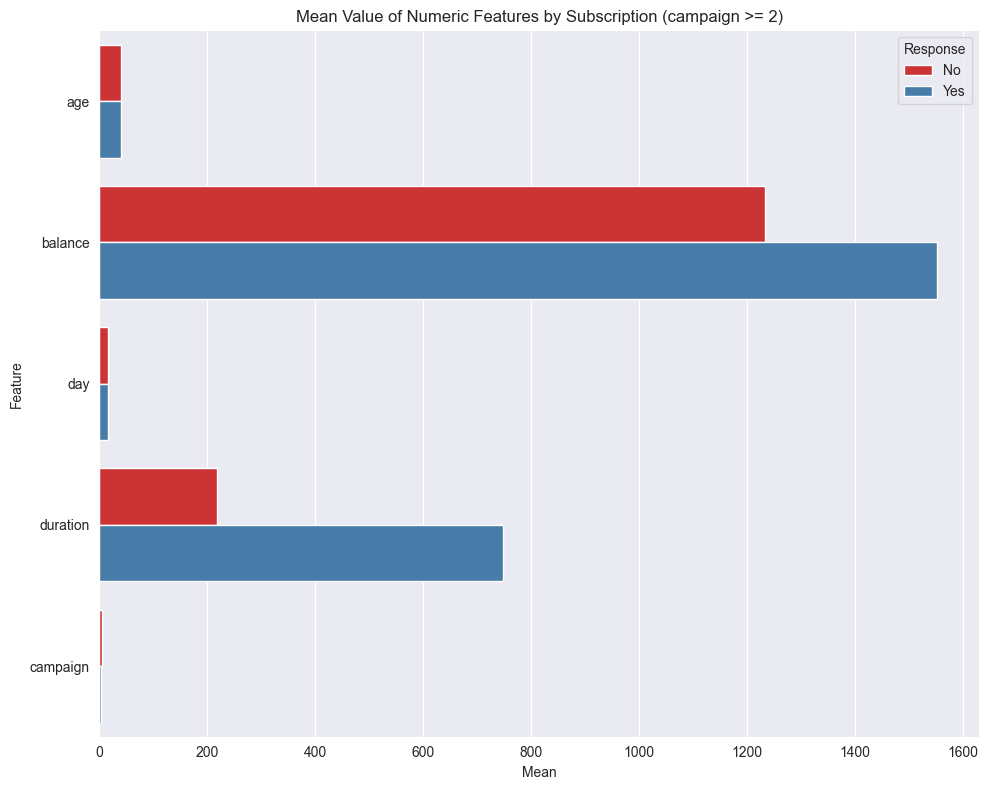

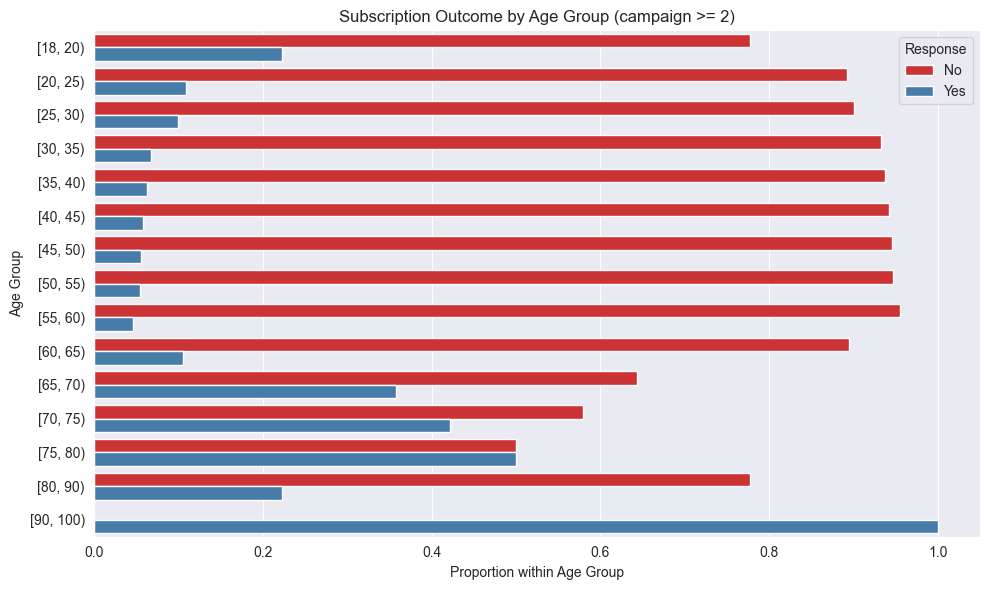

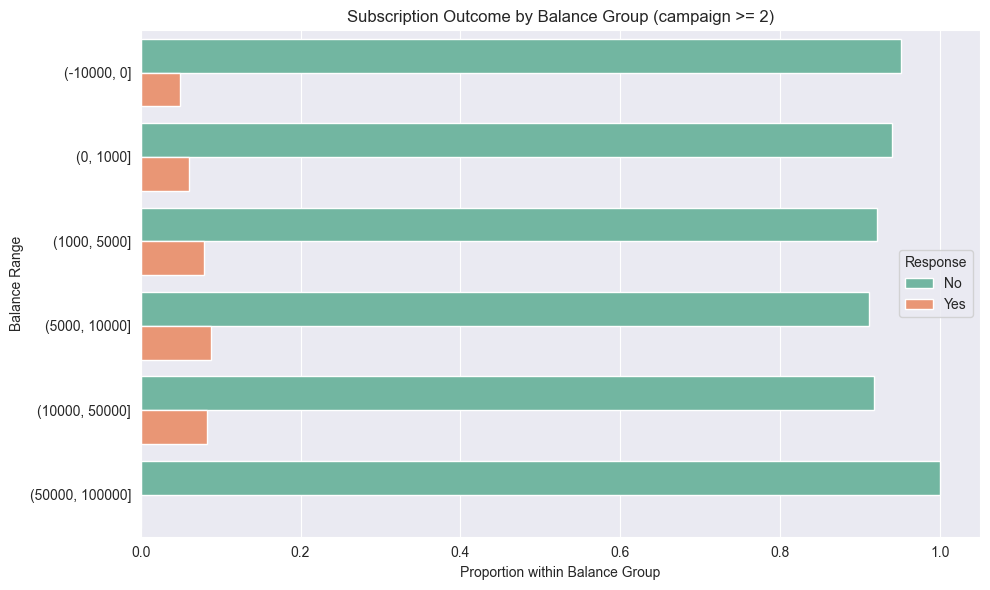

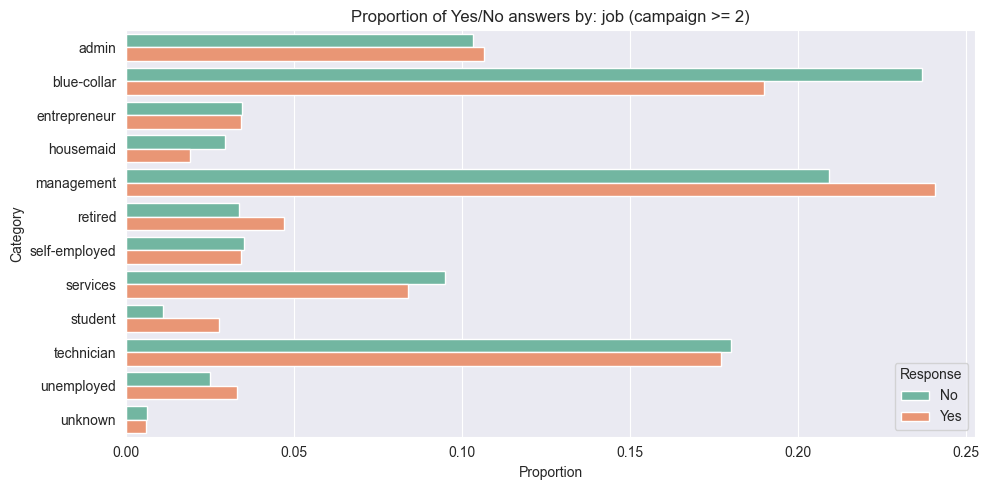

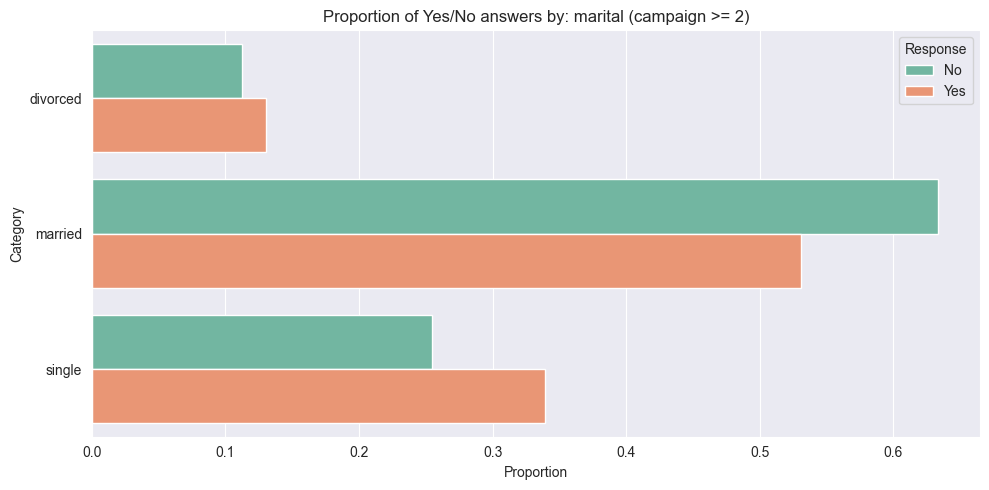

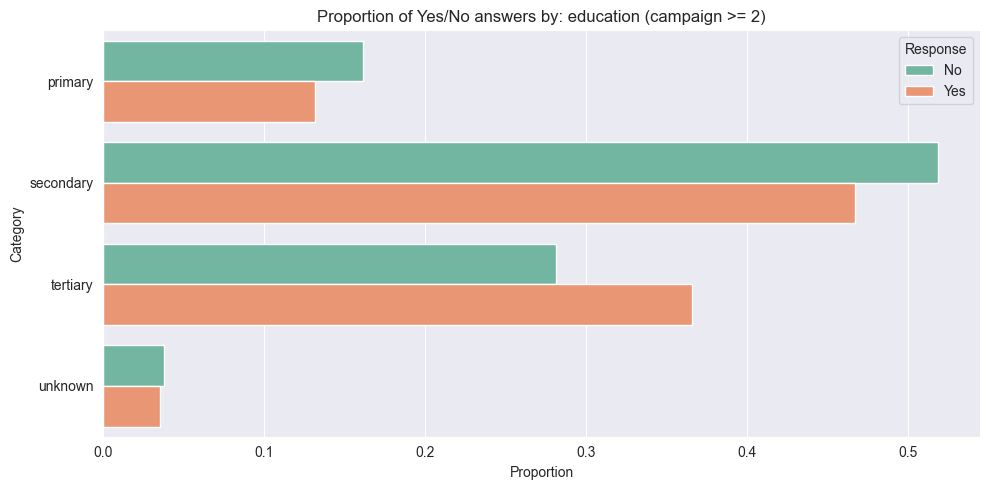

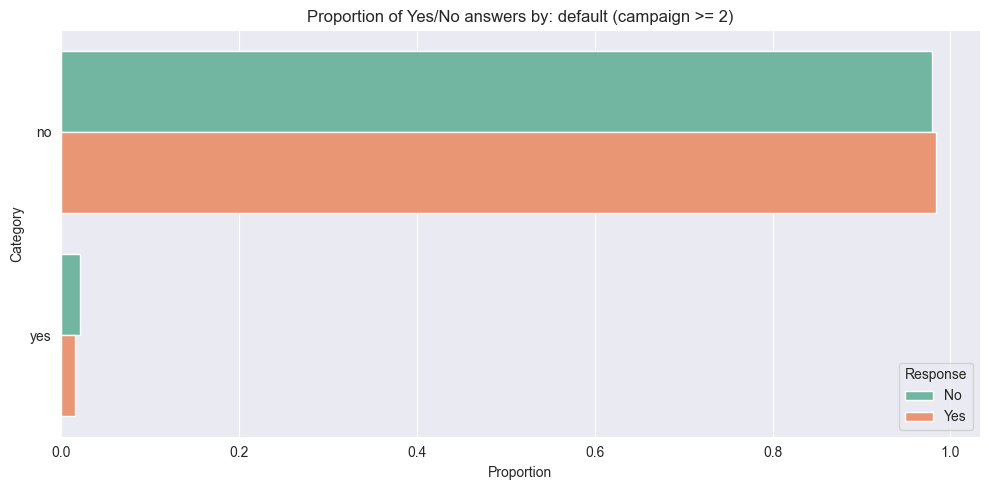

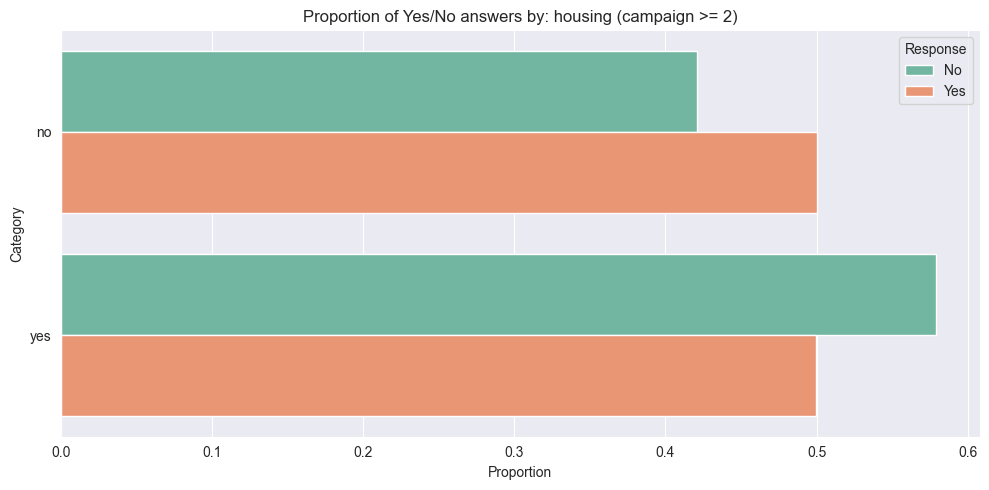

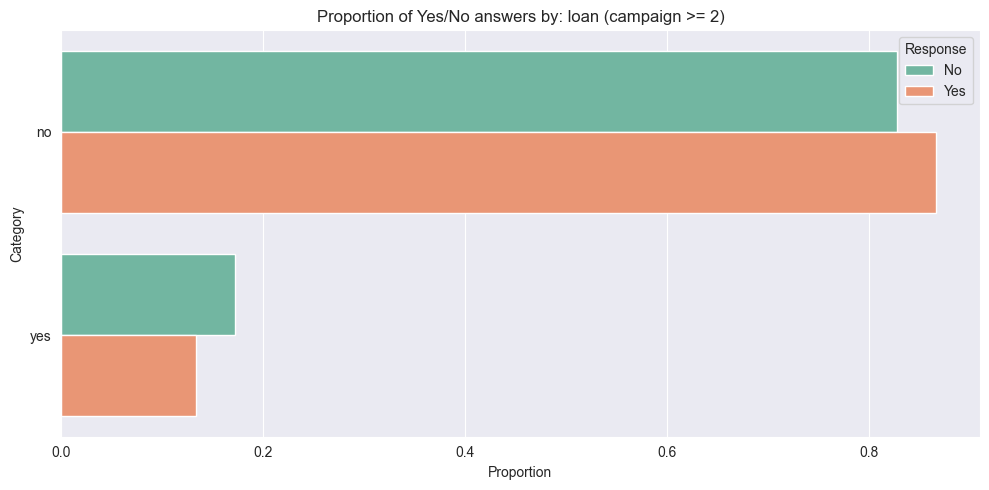

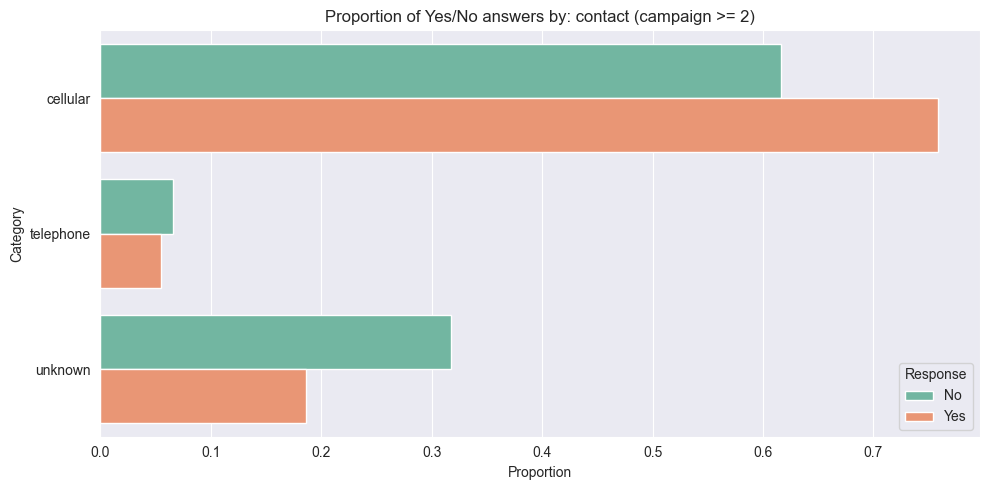

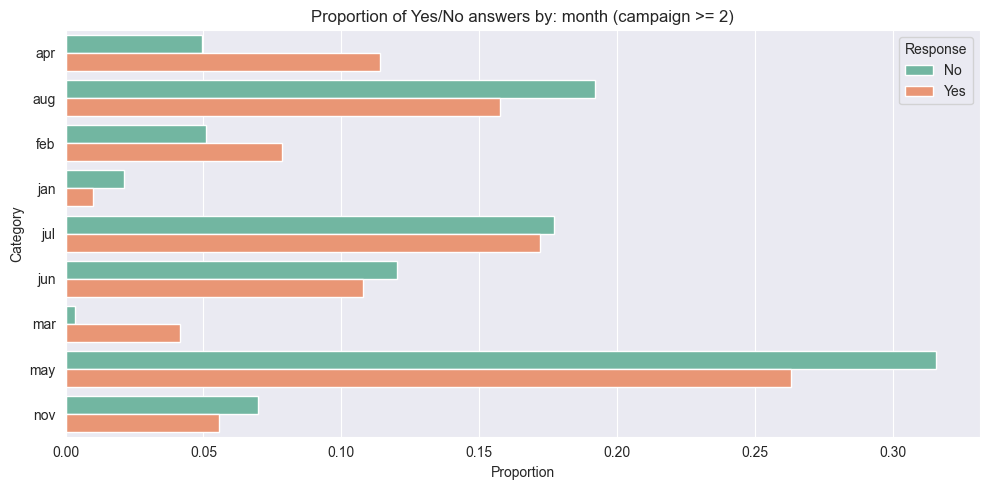

In [8]:
df_filtered = df[df['campaign'] >= 2].copy()
df_filtered['y'] = df_filtered['y'].map({'no': 0, 'yes': 1})

numeric_cols = df_filtered.select_dtypes(include=['int64', 'float64']).drop(columns='y').columns
categorical_cols = df_filtered.select_dtypes(include='object').columns

num_grouped = df_filtered.groupby('y')[numeric_cols].mean().T
num_grouped.columns = ['No', 'Yes']
num_grouped = num_grouped.reset_index().rename(columns={'index': 'Feature'})
num_melted = num_grouped.melt(id_vars='Feature', var_name='Response', value_name='Mean')

plt.figure(figsize=(10, 8))
sb.barplot(data=num_melted, y='Feature', x='Mean', hue='Response', palette='Set1')
plt.title('Mean Value of Numeric Features by Subscription (campaign >= 2)')
plt.tight_layout()
plt.show()

age_bins = [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, right=False)

age_ct = pd.crosstab(df_filtered['age_group'], df_filtered['y'], normalize='index')
age_ct.columns = ['No', 'Yes']
age_ct = age_ct.reset_index().melt(id_vars='age_group', var_name='Response', value_name='Proportion')

plt.figure(figsize=(10, 6))
sb.barplot(data=age_ct, x='Proportion', y='age_group', hue='Response', palette='Set1')
plt.title('Subscription Outcome by Age Group (campaign >= 2)')
plt.xlabel('Proportion within Age Group')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

balance_bins = [-10000, 0, 1000, 5000, 10000, 50000, 100000]
max_balance = df_filtered['balance'].max()
if max_balance > 100000:
    balance_bins.append(max_balance)
df_filtered['balance_group'] = pd.cut(df_filtered['balance'], bins=balance_bins)

balance_ct = pd.crosstab(df_filtered['balance_group'], df_filtered['y'], normalize='index')
balance_ct.columns = ['No', 'Yes']
balance_ct = balance_ct.reset_index().melt(id_vars='balance_group', var_name='Response', value_name='Proportion')

plt.figure(figsize=(10, 6))
sb.barplot(data=balance_ct, x='Proportion', y='balance_group', hue='Response', palette='Set2')
plt.title('Subscription Outcome by Balance Group (campaign >= 2)')
plt.xlabel('Proportion within Balance Group')
plt.ylabel('Balance Range')
plt.tight_layout()
plt.show()

cat_data = []

for col in categorical_cols:
    # Cross-tabulate category vs y
    cat_counts = pd.crosstab(df_filtered[col], df_filtered['y'], normalize='columns')  # Normalize to get proportions
    for category in cat_counts.index:
        cat_data.append({
            'Feature': col,
            'Category': category,
            'No': cat_counts.loc[category, 0],
            'Yes': cat_counts.loc[category, 1]
        })

cat_df = pd.DataFrame(cat_data)
cat_melted = cat_df.melt(id_vars=['Feature', 'Category'], value_vars=['No', 'Yes'], var_name='Response', value_name='Proportion')
unique_features = cat_melted['Feature'].unique()

for feat in unique_features:
    subset = cat_melted[cat_melted['Feature'] == feat]
    plt.figure(figsize=(10, 5))
    sb.barplot(data=subset, x='Proportion', y='Category', hue='Response', palette='Set2')
    plt.title(f'Proportion of Yes/No answers by: {feat} (campaign >= 2)')
    plt.tight_layout()
    plt.show()

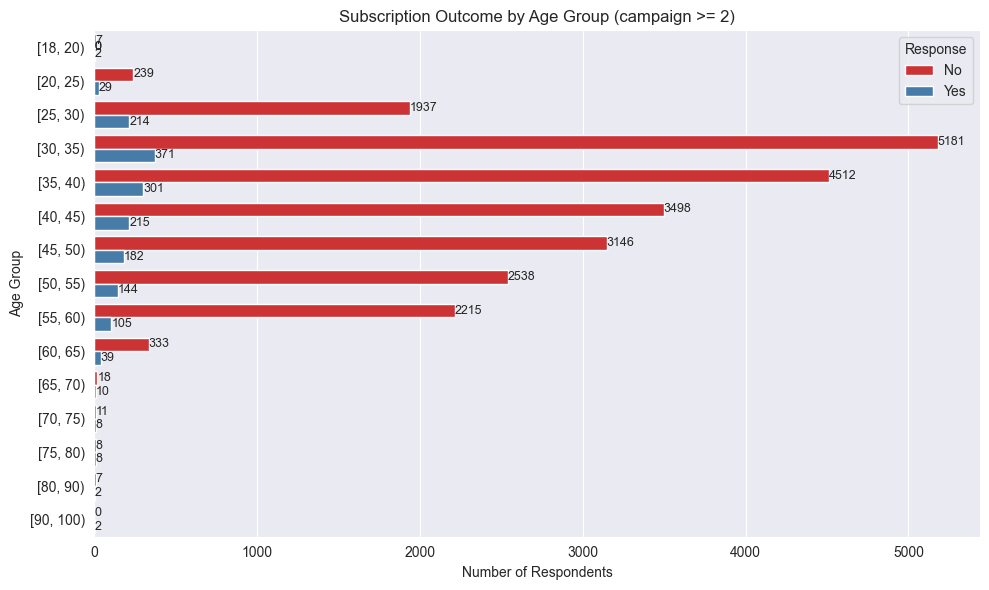

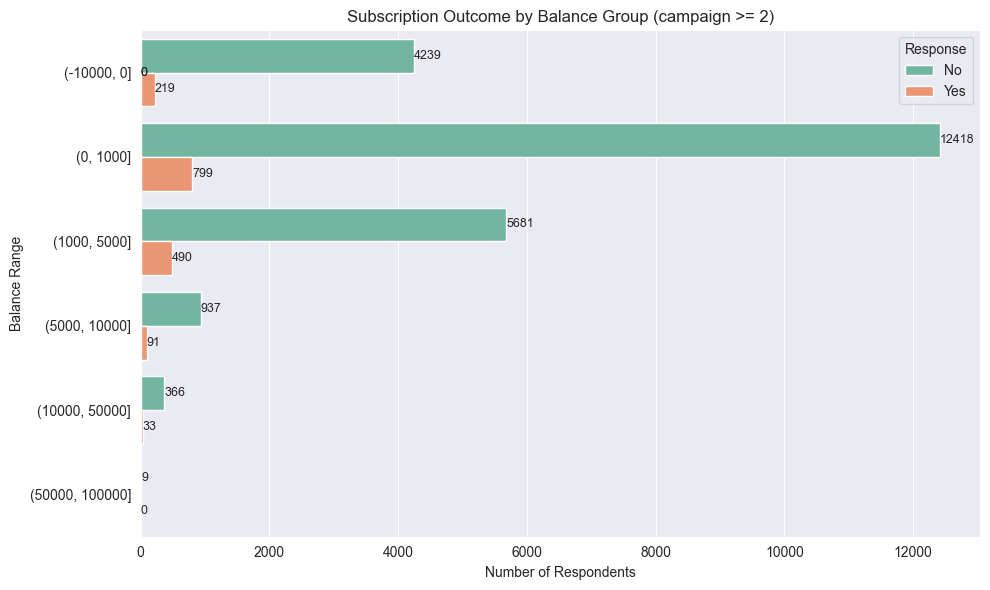

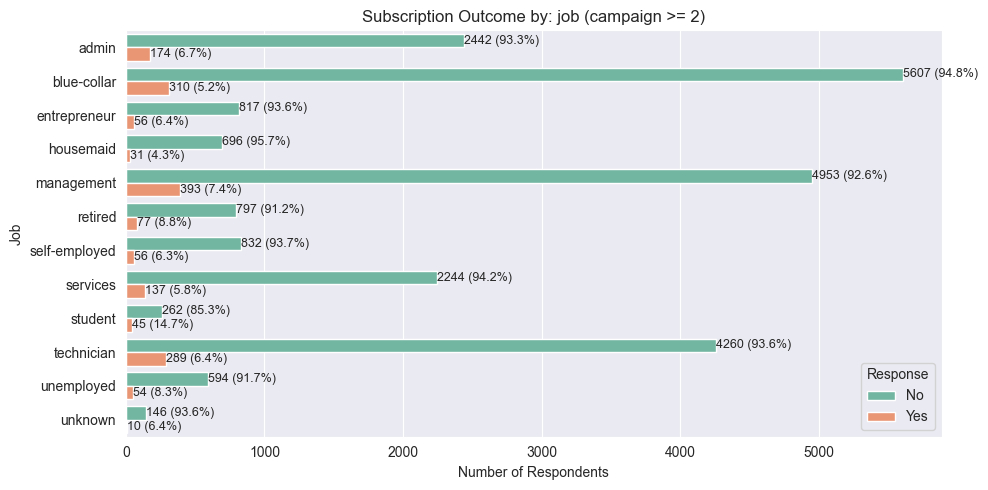

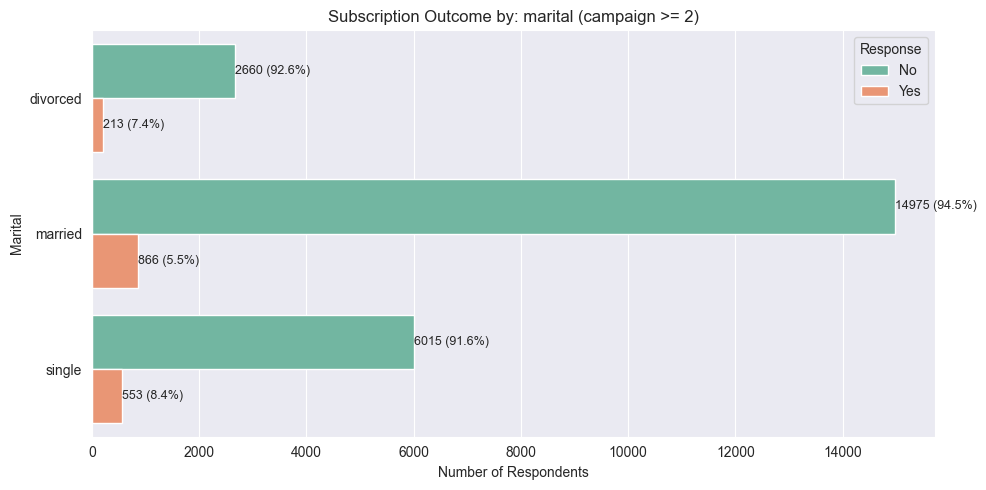

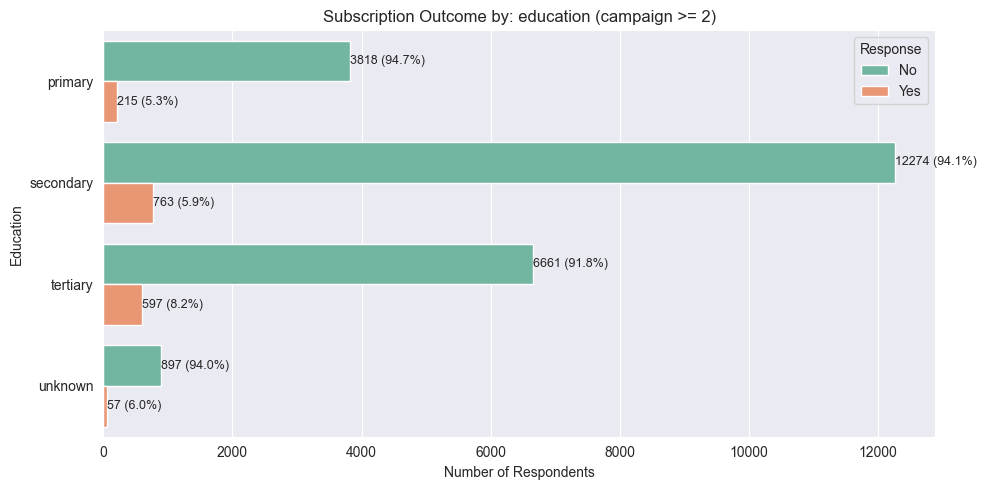

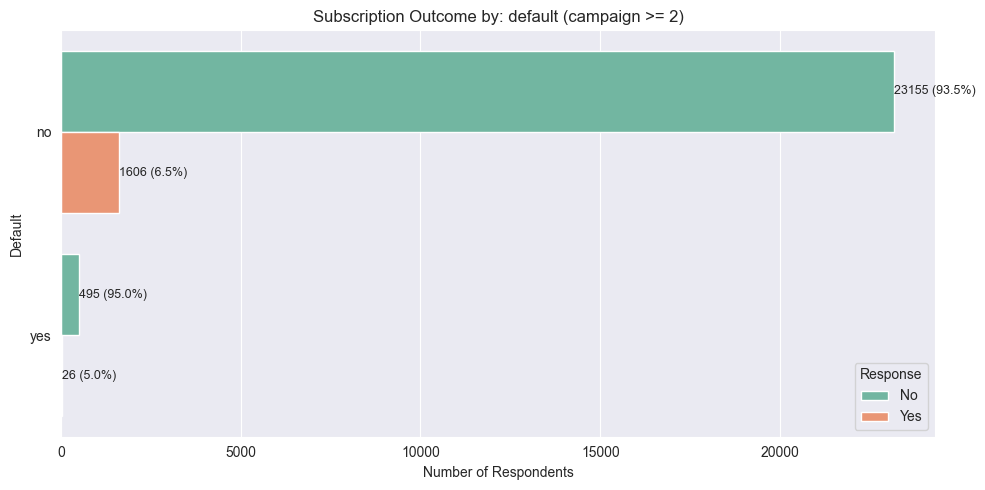

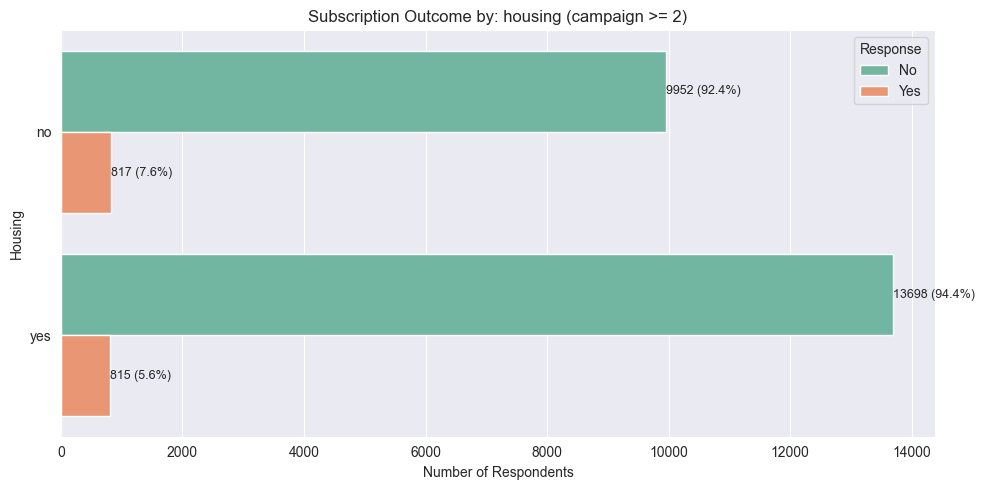

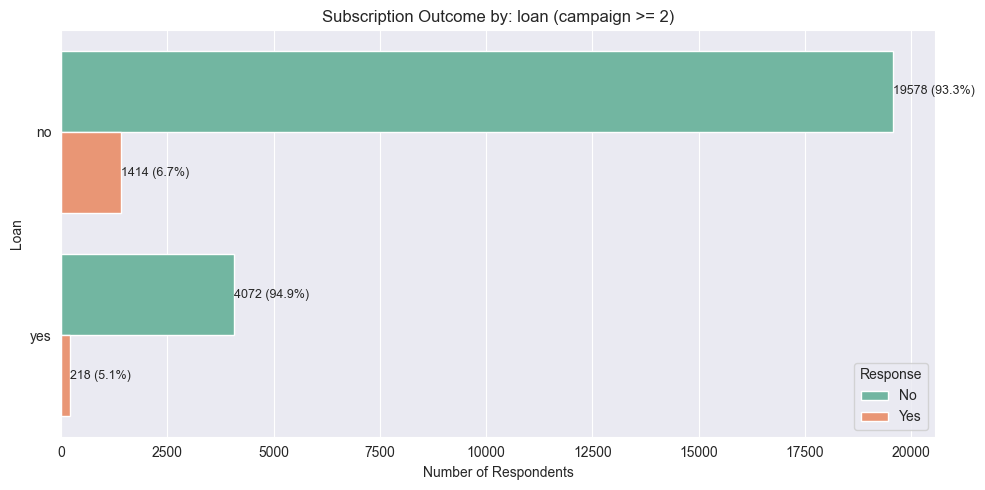

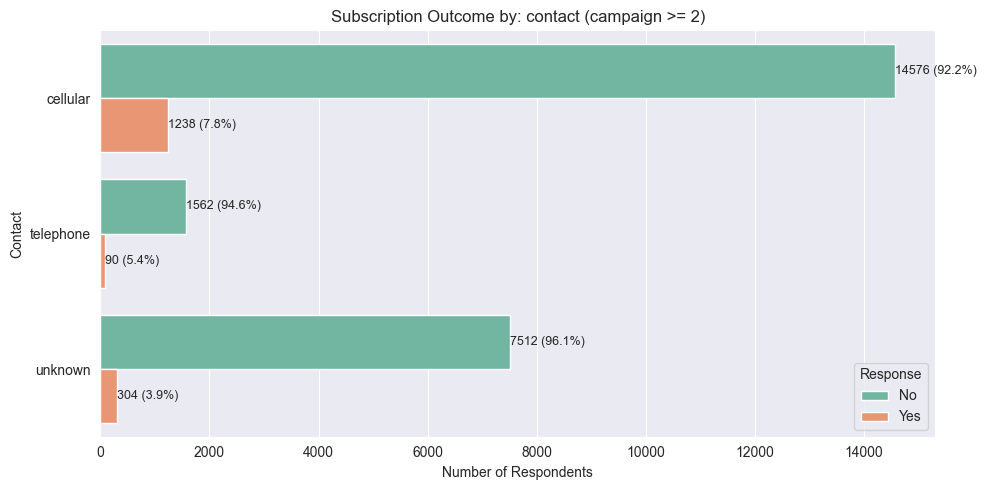

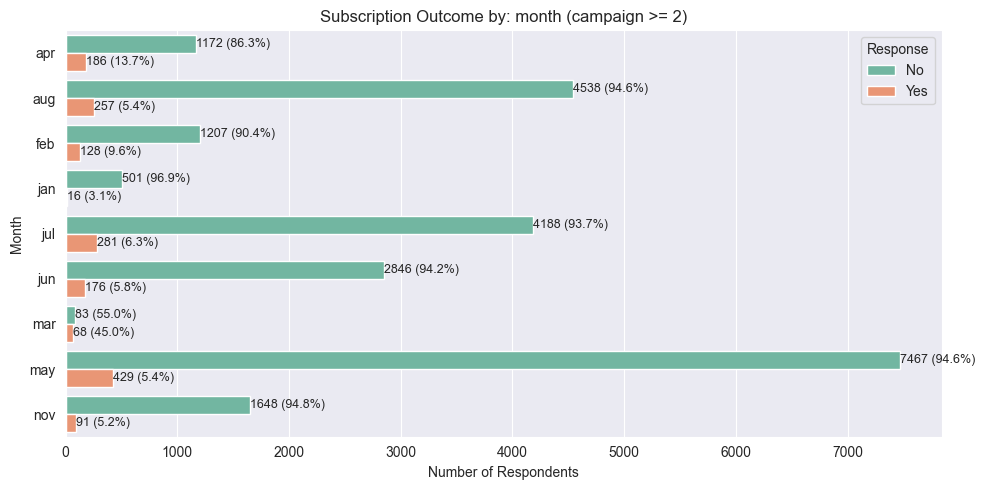

In [17]:
df_filtered = df[df['campaign'] >= 2].copy()
df_filtered['y'] = df_filtered['y'].map({'no': 0, 'yes': 1})

age_bins = [18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]
df_filtered['age_group'] = pd.cut(df_filtered['age'], bins=age_bins, right=False)

age_ct = pd.crosstab(df_filtered['age_group'], df_filtered['y'])
age_long = age_ct.reset_index().melt(id_vars='age_group', var_name='Response', value_name='Count')
age_long['Response'] = age_long['Response'].map({0: 'No', 1: 'Yes'})
totals_age = age_long.groupby('age_group')['Count'].sum().rename('Total')
age_long = age_long.merge(totals_age, on='age_group')
age_long['Percentage'] = (age_long['Count'] / age_long['Total']) * 100

plt.figure(figsize=(10, 6))
ax = sb.barplot(data=age_long, x='Count', y='age_group', hue='Response', palette='Set1')
for bar in ax.patches:
    count = int(bar.get_width())
    bar_center_y = bar.get_y() + bar.get_height() / 2
    label = f'{count}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width(), bar_center_y),
                ha='left', va='center', fontsize=9)
plt.title('Subscription Outcome by Age Group (campaign >= 2)')
plt.xlabel('Number of Respondents')
plt.ylabel('Age Group')
plt.tight_layout()
plt.show()

fixed_balance_bins = [-10000, 0, 1000, 5000, 10000, 50000, 100000]
max_balance = df_filtered['balance'].max()

if max_balance > fixed_balance_bins[-1]:
    fixed_balance_bins.append(max_balance + 1)  # Ensure it’s greater than the last bin edge

df_filtered['balance_group'] = pd.cut(df_filtered['balance'], bins=fixed_balance_bins)

balance_ct = pd.crosstab(df_filtered['balance_group'], df_filtered['y'])
balance_long = balance_ct.reset_index().melt(id_vars='balance_group', var_name='Response', value_name='Count')
balance_long['Response'] = balance_long['Response'].map({0: 'No', 1: 'Yes'})
totals_balance = balance_long.groupby('balance_group')['Count'].sum().rename('Total')
balance_long = balance_long.merge(totals_balance, on='balance_group')
balance_long['Percentage'] = (balance_long['Count'] / balance_long['Total']) * 100

plt.figure(figsize=(10, 6))
ax = sb.barplot(data=balance_long, x='Count', y='balance_group', hue='Response', palette='Set2')
for bar in ax.patches:
    count = int(bar.get_width())
    bar_center_y = bar.get_y() + bar.get_height() / 2
    label = f'{count}'
    ax.annotate(label,
                xy=(bar.get_x() + bar.get_width(), bar_center_y),
                ha='left', va='center', fontsize=9)
plt.title('Subscription Outcome by Balance Group (campaign >= 2)')
plt.xlabel('Number of Respondents')
plt.ylabel('Balance Range')
plt.tight_layout()
plt.show()

categorical_cols = df_filtered.select_dtypes(include='object').columns

def annotate_bars_using_labels(ax, data, group_col):
    yticklabels = [tick.get_text() for tick in ax.get_yticklabels()]
    for bar in ax.patches:
        bar_center_y = bar.get_y() + bar.get_height() / 2
        closest_tick_index = int(round(bar_center_y))
        if 0 <= closest_tick_index < len(yticklabels):
            category = yticklabels[closest_tick_index]
            count = int(bar.get_width())
            match = data[(data[group_col] == category) & (data['Count'] == count)]
            if not match.empty:
                pct = match['Percentage'].values[0]
                label = f'{count} ({pct:.1f}%)'
                ax.annotate(label,
                            xy=(bar.get_x() + bar.get_width(), bar.get_y() + bar.get_height() / 2),
                            ha='left', va='center', fontsize=9)

def generate_chart_with_annotations(col):
    cat_counts = pd.crosstab(df_filtered[col], df_filtered['y'])
    cat_long = cat_counts.reset_index().melt(id_vars=col, var_name='Response', value_name='Count')
    cat_long['Response'] = cat_long['Response'].map({0: 'No', 1: 'Yes'})
    totals = cat_long.groupby(col)['Count'].sum().rename('Total')
    cat_long = cat_long.merge(totals, on=col)
    cat_long['Percentage'] = (cat_long['Count'] / cat_long['Total']) * 100

    plt.figure(figsize=(10, 5))
    ax = sb.barplot(data=cat_long, x='Count', y=col, hue='Response', palette='Set2')
    annotate_bars_using_labels(ax, cat_long, col)
    plt.title(f'Subscription Outcome by: {col} (campaign >= 2)')
    plt.xlabel('Number of Respondents')
    plt.ylabel(col.capitalize())
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    generate_chart_with_annotations(col)

# Conclusion

The goal of this project was to review and examine call center data and improve the response ratings received so that more 'yes' answers would be received in contrast to the high volume of 'no' answers that were shown in the data provided. There were several pieces of demographic data provided that was used to help determine individuals who might be more likely to respond with a 'yes'. Based on the results and looking at the initial outreach campaign and future outreach campaigns, we can safely determine a few factors that will likely make someone a subscriber, both during the initial first campaign and any potential future campaign outreaches.

- Young individuals had a slight chance to say 'yes' during the campaign that dropped as the age went up. However, after about age 65 the 'yes' answers increased drastically and were much higher in general than the overall.
- Account balances had an extremely minor impact on whether respondents said 'yes' or 'no', though it was noted that individuals who had account balances over $50,000 were extremely unlikely to say 'yes'
- The best respondents had jobs that involved being an admin, being in management, being a student, unemployed, or retired. Several of these jobs also seemed to be loosely supported by the age differences in respondents.
- Respondents who were single or divorced were much more likely to say 'yes' than respondents who were currently married
- Education did appear to play a bit of a role, as more educated individual;s had a higher chance of saying 'yes' with respondents having a tertiary education more likely to say 'yes' overall.
- Respondents without housing at the time of the campaign were slightly more likely to say 'yes' than respondents with housing
- Respondents who currently had a loan were more likely to say 'yes' than those without one
- Respondents who had contact via cellular or telephone were more likely to say 'yes' than those contacted via other means
- Three months in particular showed a much higher average of people saying 'yes' overall: April, February, and March

There are a number of features that were pulled into the data. But after several rounds of evaluating, we can create a profile of whom would likely be our best candidates for saying 'yes' to our clients term deposit. The most likely candidates to subscribe will slightly older, often above age 65, be currently retired or if still working involved in administration or management, be either single or divorced when it comes to their marital status, and have at least a tertiary education. An individual fitting as many qualities of this profile would be most likely to say yes, and I recommend that would be the best target for any future campaigns. Other factors to consider would be the call duration, as longer calls had respondents more willing to say yes or give both in the initial outreach and all future campaigns.